In [ ]:
!mkdir results

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

In [ ]:
import random

Data Preperation

In [ ]:
gdf_urban_core_gu = pd.read_csv('/content/gdf_urban_core_gu.csv')
gdf_urban_core_gu= gdf_urban_core_gu.drop(['Unnamed: 0'], axis=1)
#gdf_urban_core_gu

In [ ]:
idx = pd.date_range('2018-04-01 00:00:00','2018-04-30 23:55:00',freq='5min')
idx = idx.astype('str')

In [ ]:
ex_core=gdf_urban_core_gu[idx.to_list()]
ex_core=ex_core.T
ex_core=ex_core.reset_index()
ex_core=ex_core.drop(['index'],axis=1)
ex_core=ex_core.T
ex_core

0      1      2      3      4      5      6      7      8      9     \
0    49.39  49.74  48.69  49.04  50.71  49.46  49.06  50.26  50.86  50.31   
1    53.34  52.38  53.20  53.53  52.62  54.08  53.13  52.49  53.36  52.85   
2    39.47  39.22  38.84  34.21  44.50  38.28  37.69  50.92  37.50  48.58   
3    29.02  34.66  34.49  42.51  36.78  40.59  36.67  40.97  39.80  39.69   
4    48.33  46.12  50.23  45.12  51.00  46.51  49.90  55.03  51.77  48.57   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
255  28.10  25.52  30.10  27.32  25.70  29.84  28.07  29.89  31.12  28.11   
256  32.82  33.60  29.65  33.75  32.96  32.65  32.48  32.44  34.08  31.80   
257  25.62  30.61  32.02  26.06  27.91  27.01  31.08  24.14  26.52  26.08   
258  26.38  22.98  28.07  23.10  25.78  29.00  26.43  23.99  23.87  28.31   
259  29.03  27.86  26.80  29.16  30.48  29.46  25.48  28.34  27.96  28.18   

     ...   8630   8631   8632   8633   8634   8635   8636   8637   8638   8639  
0    ...  49.58  48.15  48.96  49.07  49.03  48.96  49.44  48.72  49.80  49.58  
1    ...  51.13  51.34  51.28  51.90  51.91  50.70  50.95  51.55  52.99  52.20  
2    ...  35.42  36.83  36.93  36.18  35.79  34.78  35.94  36.47  34.78  35.21  
3    ...  29.60  32.36  32.66  33.09  33.77  30.38  48.38  36.53  33.29  33.24  
4    ...  46.60  50.99  51.81  48.02  48.25  47.16  48.07  46.30  47.90  52.10  
..   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  
255  ...  19.09  27.41  20.96  26.64  26.38  25.84  28.99  24.73  28.07  26.10  
256  ...  27.20  26.84  26.39  26.04  27.03  27.52  28.61  29.76  29.95  29.81  
257  ...  26.44  26.59  24.86  25.23  29.95  27.14  29.00  24.13  29.59  24.51  
258  ...  20.57  25.53  25.95  24.01  23.34  21.64  24.53  25.15  22.54  25.28  
259  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  

[260 rows x 8640 columns]

In [ ]:
import numpy as np

# Extract timestamp columns
timestamp_cols = ex_core.columns
timestamps_data = ex_core.loc[:, timestamp_cols].values

# Define the number of timestamps per image and number of "Link ID"s
num_timestamps_per_image = 8
num_link_ids = timestamps_data.shape[0]

# Create spatio-temporal images
num_images = timestamps_data.shape[1] - num_timestamps_per_image +1
spatio_temporal_images = np.array([
    timestamps_data[:, i:i+num_timestamps_per_image]
    for i in range(num_images)
])

# Shape of spatio_temporal_images: [num_images, num_link_ids, num_timestamps_per_image]

In [ ]:
spatio_temporal_images.shape

(8633, 260, 8)

[0] input data 생성

In [ ]:
temp_target =spatio_temporal_images[:, :, :2]
final_y_data = temp_target[1:]
final_y_data.shape

(8632, 260, 2)

In [ ]:
final_x_data =spatio_temporal_images[:-1]
final_x_data.shape

(8632, 260, 8)

[1] Train/Test/Val 분할

In [ ]:
from sklearn.model_selection import train_test_split

# Define the size of the test set
test_size = 0.23

# First split: Separate out the test set
X_temp, X_test_, y_temp, y_test_ = train_test_split(
    final_x_data, final_y_data, test_size=test_size, random_state=42
)

val_size = 0.07 / (1 - test_size)

# Second split: Separate out the validation set from the (temporary) training set
X_train_, X_val_, y_train_, y_val_ = train_test_split(
    X_temp, y_temp, test_size=val_size, random_state=42
)

In [ ]:
X_train_.shape

(6041, 260, 8)

In [ ]:
y_train_.shape

(6041, 260, 2)

[2] MinMaxScaling


In [ ]:

from sklearn.preprocessing import MinMaxScaler    #ReLU에서 음수는 다 0으로 처리하여 MinMaxScaler 적용


# Initialize a scaler
X_scaler = MinMaxScaler()
X_scaler.fit(X_train_.reshape(-1,8))

y_scaler = MinMaxScaler()
y_scaler.fit(y_train_.reshape(-1,2))

scaled_X_train = X_scaler.transform(X_train_.reshape(-1,8)).reshape(X_train_.shape)
scaled_y_train = y_scaler.transform(y_train_.reshape(-1,2)).reshape(y_train_.shape)

scaled_X_test = X_scaler.transform(X_test_.reshape(-1,8)).reshape(X_test_.shape)
scaled_y_test = y_scaler.transform(y_test_.reshape(-1, 2)).reshape(y_test_.shape)

scaled_X_val = X_scaler.transform(X_val_.reshape(-1, 8)).reshape(X_val_.shape)
scaled_y_val = y_scaler.transform(y_val_.reshape(-1, 2)).reshape(y_val_.shape)


[3] torch로 변환, partition으로 생성

In [ ]:
X_train = torch.tensor(scaled_X_train, dtype=torch.float32)
y_train = torch.tensor(scaled_y_train, dtype=torch.float32)
X_train = X_train.unsqueeze(1)   # (num_images, 1, height, width) 로 num_channel = 1 추가
y_train = y_train.unsqueeze(1)

X_val = torch.tensor(scaled_X_val, dtype=torch.float32)
y_val = torch.tensor(scaled_y_val, dtype=torch.float32)
X_val = X_val.unsqueeze(1)
y_val = y_val.unsqueeze(1)

X_test = torch.tensor(scaled_X_test, dtype=torch.float32)
y_test = torch.tensor(scaled_y_test, dtype=torch.float32)
X_test = X_test.unsqueeze(1)
y_test = y_test.unsqueeze(1)

In [ ]:
X_test.shape

torch.Size([1986, 1, 260, 8])

In [ ]:
y_test.shape

torch.Size([1986, 1, 260, 2])

In [ ]:
from torch.utils.data import TensorDataset

trainset = TensorDataset(X_train, y_train)
valset = TensorDataset(X_val, y_val)
testset = TensorDataset(X_test, y_test)

In [ ]:
partition = {'train': trainset, 'val':valset, 'test':testset}

Model Code

In [ ]:
cfg = {
    'Depth1' : [],
    'Depth2' : [64, 'M'],
    'Depth3' : [128, 'M', 64, 'M'],
    'Depth4' : [256, 'M', 128, 'M', 64],
}

class CNN

In [ ]:
class CNN(nn.Module):

    def __init__(self, model_code, in_channels, out_dim, act, use_bn, dropout, hid_dim):
        super(CNN, self).__init__()


        if act == 'relu' :
            self.act = nn.ReLU()
        elif act == 'sigmoid' :
            self.act = nn.Sigmoid()
        elif act == 'tanh' :
            self.act = nn.Tanh()
        else :
            raise ValueError("Not a valid activation function code")



        self.layers = self._make_layers(model_code, in_channels, use_bn)

        dummy_input = torch.zeros(1, in_channels, 304, 8)
        flatten_size = self._get_flattened_size(dummy_input)
        self.classifier = nn.Sequential(nn.Linear(flatten_size, out_dim),
                                        )


    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        x = x.view(x.size(0), 1, 304, 2)
        return x

    def _make_layers(self, model_code, in_channels, use_bn) :
        layers = []

        if cfg[model_code] == []:
            self.is_mlp_mode = True     # MLP 모드로 전환
            return nn.Identity()

        else:
          self.is_mlp_mode = False
          for x in cfg[model_code] :
              if x == 'M':
                  layers += [nn.MaxPool2d(kernel_size =2, stride = 2)]

              else:
                  layers += [nn.Conv2d(in_channels=in_channels,
                                      out_channels = x,
                                      kernel_size=3,
                                      stride =1,
                                      padding =1) ]


                  if use_bn :
                        layers += [nn.BatchNorm2d(x)]
                  layers += [self.act]

                  in_channels = x
          return nn.Sequential(*layers)


    def _get_flattened_size(self, x) :
        x = self.layers(x)
        return x.view(x.size(0), -1).size(1)

class MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_shape, out_dim, hid_dim, n_layer, act, dropout, use_bn, ):
        super(MLP, self).__init__()

        # ====== Create Activation Function ====== #
        if act == 'relu':
            self.act = nn.ReLU()
        elif act == 'tanh':
            self.act = nn.Tanh()
        elif act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('No valid activation function selected!')

        # input_shape 예: (batch_size, channels, height, width)
        self.in_dim = in_shape[1]*in_shape[2]*in_shape[3]
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act_name = act
        self.dropout = dropout
        self.use_bn = use_bn


        # ===== nn.Sequential로 layer 생성 ====== #
        layers = [
            nn.Linear(self.in_dim, hid_dim),
            self.act,
                ]
        if use_bn:
            layers.append(nn.BatchNorm1d(hid_dim))

        layers.append(nn.Dropout(dropout))

        for _ in range(n_layer - 1):
            layers.append(nn.Linear(hid_dim, hid_dim))
            layers.append(self.act)
            if use_bn:
                layers.append(nn.BatchNorm1d(hid_dim))

            layers.append(nn.Dropout(dropout))

        layers.append(nn.Linear(hid_dim, out_dim))

        self.classifier = nn.Sequential(*layers)


        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)


    def forward(self, x):
        x= x.view(x.size(0),-1)
        x = self.classifier(x)
        x = x.view(x.size(0), 1, 304, 2)
        return x



In [ ]:
def train(net, partition, optimizer, criterion, args):

    trainloader = torch.utils.data.DataLoader(partition['train'],
                                              batch_size=args.train_batch_size,
                                              shuffle=True, num_workers=2)
    net.train()


    mae_criterion = nn.L1Loss()    #MAE 값 계산을 위해 추가


    total = 0
    train_loss = 0.0
    train_mae = 0
    batch_orig_mse = 0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad()

        # get the inputs
        inputs, labels = data

        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        total += labels.size(0)
        mae = mae_criterion(outputs, labels)
        train_mae += mae.item() * inputs.size(0)

        # Inversed scaled MSE
        if y_scaler is not None:
            outputs_np = outputs.detach().cpu().numpy().reshape(-1, 2)
            labels_np = labels.detach().cpu().numpy().reshape(-1, 2)

            outputs_orig = y_scaler.inverse_transform(outputs_np).reshape(outputs.shape)
            labels_orig = y_scaler.inverse_transform(labels_np).reshape(labels.shape)

            orig_loss = np.mean((outputs_orig - labels_orig)**2)
            batch_orig_mse += orig_loss.item() * inputs.size(0)


    train_loss = train_loss / total
    train_mae_loss = train_mae / total

    train_orig_loss = batch_orig_mse / total if y_scaler is not None else None


    return net, train_loss, train_orig_loss, train_mae_loss

In [ ]:
def validate(net, partition, criterion, args):

    valloader = torch.utils.data.DataLoader(partition['val'],
                                            batch_size=args.test_batch_size,
                                            shuffle=False, num_workers=2)
    net.eval()

    mae_criterion = nn.L1Loss()

    total = 0
    val_loss = 0
    batch_orig_mse = 0
    val_mae = 0
    val_mae_orig = 0

    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            total += labels.size(0)

            mae = mae_criterion(outputs, labels)
            val_mae += mae.item() * inputs.size(0)


            if y_scaler is not None:
                outputs_np = outputs.detach().cpu().numpy().reshape(-1, 2)
                labels_np = labels.detach().cpu().numpy().reshape(-1, 2)

                outputs_orig = y_scaler.inverse_transform(outputs_np).reshape(outputs.shape)
                labels_orig = y_scaler.inverse_transform(labels_np).reshape(labels.shape)

                batch_mae = np.mean(np.abs(outputs_orig - labels_orig))
                val_mae_orig += batch_mae * inputs.size(0)
                orig_loss = np.mean((outputs_orig - labels_orig)**2)
                batch_orig_mse += orig_loss.item() * inputs.size(0)


        val_loss = val_loss / total
        val_orig_loss = batch_orig_mse / total if y_scaler is not None else None
        val_mae_loss = val_mae / total
        val_mae_orig_loss = val_mae_orig / total if y_scaler is not None else None


    return val_loss, val_orig_loss, val_mae_loss, val_mae_orig_loss

In [ ]:
def test(net, partition, args):

    testloader = torch.utils.data.DataLoader(partition['test'],
                                             batch_size=args.test_batch_size,
                                             shuffle=False, num_workers=2)
    net.eval()

    mse_criterion = nn.MSELoss()
    mae_criterion = nn.L1Loss()

    test_mse = 0
    batch_orig_mse = 0
    test_mae = 0
    test_mae_orig = 0

    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = net(inputs)

            mse = mse_criterion(outputs, labels)
            mae = mae_criterion(outputs, labels)

            total += labels.size(0)
            test_mse += mse.item() * inputs.size(0)
            test_mae += mae.item() * inputs.size(0)


            if y_scaler is not None:
                outputs_np = outputs.detach().cpu().numpy().reshape(-1, 2)
                labels_np = labels.detach().cpu().numpy().reshape(-1, 2)

                outputs_orig = y_scaler.inverse_transform(outputs_np).reshape(outputs.shape)
                labels_orig = y_scaler.inverse_transform(labels_np).reshape(labels.shape)

                batch_mae = np.mean(np.abs(outputs_orig - labels_orig))
                test_mae_orig += batch_mae * inputs.size(0)
                orig_loss = np.mean((outputs_orig - labels_orig)**2)
                batch_orig_mse += orig_loss.item() * inputs.size(0)

        test_mse_loss = test_mse / total
        test_orig_loss = batch_orig_mse / total if y_scaler is not None else None
        test_mae_loss = test_mae / total
        test_mae_orig_loss = test_mae_orig / total if y_scaler is not None else None

    return test_mse_loss, test_orig_loss, test_mae_loss, test_mae_orig_loss

Early Stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

Experiment

In [ ]:
def experiment(partition, args):

    trainloader = torch.utils.data.DataLoader(
        partition['train'],
        batch_size=args.train_batch_size,
        shuffle=True,
        num_workers=2
          )

    sample_inputs, _ = next(iter(trainloader))
    sample_inputs = sample_inputs.cuda()
    in_shape = sample_inputs.shape


    if args.model_type == 'CNN':

        net = CNN(model_code = args.model_code,
                  in_channels = args.in_channels,
                  out_dim = args.out_dim,
                  act = args.act,
                  use_bn= args.use_bn,
                  dropout = args.dropout,
                  hid_dim = args.hid_dim)

    elif args.model_type == 'MLP':
        net = MLP(
            in_shape=in_shape,
            out_dim=args.out_dim,
            hid_dim=args.hid_dim,
            n_layer=args.n_layer,
            act=args.act,
            dropout=args.dropout,
            use_bn=args.use_bn
        )
    else:
        raise ValueError(f"Invalid model_type: {args.model_type}")

    net.cuda()

    criterion = nn.MSELoss()  #회귀용 손실함수 사용
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')


    # EarlyStopping 인스턴스 생성
    early_stopping = EarlyStopping(patience=7, min_delta=0.00001) if args.use_early_stopping else None


    # ReduceLROnPlateau 스케줄러 설정
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=3, factor=0.1, min_lr=1e-6,
        threshold=1e-3, threshold_mode='abs') if args.use_scheduler else None

    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_mae_losses = []
    val_mae_losses = []
    val_mae_orig_losses = []
    # ===================================== #
    best_metric = float('inf')

    for epoch in range(args.epoch):
        ts = time.time()
        net, train_loss, train_orig_loss, train_mae_loss = train(net, partition, optimizer, criterion, args)
        val_loss, val_orig_loss, val_mae_loss, val_mae_orig_loss = validate(net, partition, criterion, args)
        te = time.time()

        #====schduler에 val_loss 전달====
        if args.use_scheduler:
            scheduler.step(val_loss)
        #====early stopping 에 val_loss 전달====
        if args.use_early_stopping:
            early_stopping(val_loss)
            if early_stopping.early_stop :
                  print("Early stopping triggered!")
                  break


        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_mae_losses.append(train_mae_loss)
        val_mae_losses.append(val_mae_loss)
        val_mae_orig_losses.append(val_mae_orig_loss)
        # ============================ #

        setting = deepcopy(vars(args))
        del setting['epoch']
        hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
        os.makedirs('./checkpoints', exist_ok=True)
        model_path = f'./checkpoints/{args.exp_name}-{hash_key}.pth'

        if val_loss < best_metric:
            best_metric = val_loss
            torch.save(net.state_dict(), model_path)

        current_lr = scheduler.get_last_lr()[0] if args.use_scheduler else args.lr
        print('Epoch {}, Loss(train/val) {:2.4f}/{:2.4f}, MAELoss(train/val) {:2.4f}/{:2.4f}, MAE_origLoss(val) {:2.4f}. Took {:2.2f} sec, Current LR {:2.6f}'.format(epoch, train_loss, val_loss, train_mae_loss, val_mae_loss, val_mae_orig_loss, te-ts, current_lr))

    test_loss, test_orig_loss, test_mae_loss, test_mae_orig_loss = test(net, partition, args)

    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_mae_losses'] = train_mae_losses
    result['val_mae_losses'] = val_mae_losses
    result['val_mae_orig_losses'] = val_mae_orig_losses
    result['train_mse'] = train_loss
    result['val_mse'] = val_loss
    result['test_mse'] = test_loss
    result['train_mae'] = train_mae_loss
    result['val_mae'] = val_mae_loss
    result['test_mae'] = test_mae_loss
    result['train_orig_loss'] = train_orig_loss
    result['test_orig_loss'] = test_orig_loss
    result['val_mae_orig_loss'] = val_mae_orig_loss
    result['test_mae_orig_loss'] = test_mae_orig_loss

    return vars(args), result
    # ===================================== #

Save and Load experiment result

In [ ]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd
from google.colab import files

def convert_np(obj):
    if isinstance(obj, (np.integer, np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.bool_)):
        return bool(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    return str(obj)


def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    result['hash_key'] = hash_key

    with open(filename, 'w') as f:
        json.dump(result, f, default=convert_np, indent=2)

    return hash_key      # 추가

def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result)
    return df

Visualization (1)

In [ ]:
def plot_mse_loss(var1, var2, df, order=None):
    if order:
      df[var1] = pd.Categorical(df[var1], categories=order, ordered=True)
    fig, ax = plt.subplots(1, 4)
    fig.set_size_inches(15, 4)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_mse', hue=var2, data=df, ax=ax[0], order=order)
    sns.barplot(x=var1, y='val_mse', hue=var2, data=df, ax=ax[1], order=order)
    sns.barplot(x=var1, y='test_mse', hue=var2, data=df, ax=ax[2], order=order)
    sns.barplot(x=var1, y='test_orig_loss', hue=name_var2, data=df, ax=ax[3], order=order)

    ax[0].set_title('Train MSE Loss')
    ax[1].set_title('Validation MSE Loss')
    ax[2].set_title('Test MSE Loss')
    ax[3].set_title('Test Orig MSE Loss')

    ax[0].get_legend().remove()
    ax[1].get_legend().remove()
    ax[2].get_legend().remove()
    ax[3].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title=var2)

    plt.tight_layout()

def plot_mae_loss(var1, var2, df, order=None):
    if order:
      df[var1] = pd.Categorical(df[var1], categories=order, ordered=True)
    fig, ax = plt.subplots(1, 4)
    fig.set_size_inches(15, 4)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_mae', hue=var2, data=df, ax=ax[0], order=order)
    sns.barplot(x=var1, y='val_mae', hue=var2, data=df, ax=ax[1], order=order)
    sns.barplot(x=var1, y='test_mae', hue=var2, data=df, ax=ax[2], order=order)
    sns.barplot(x=var1, y='test_mae_orig_loss', hue=name_var2, data=df, ax=ax[3], order=order)

    ax[0].set_title('Train MAE Loss')
    ax[1].set_title('Validation MAE Loss')
    ax[2].set_title('Test MAE Loss')
    ax[3].set_title('Test Orig MAE Loss')

    ax[0].get_legend().remove()
    ax[1].get_legend().remove()
    ax[2].get_legend().remove()
    ax[3].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title=var2)

    plt.tight_layout()

Visualization (2)

In [ ]:
def plot_loss_variation(var1, var2, df, order_var1=None, order_var2=None,  **kwargs ) :


  list_v1 = df[var1].unique()
  list_v2 = df[var2].unique()
  list_data = []

  for value1 in list_v1:
      for value2 in list_v2:
          row = df.loc[df[var1]==value1]
          row = row.loc[row[var2]==value2]

          train_losses = list(row.train_losses)[0]
          val_losses = list(row.val_losses)[0]
          test_mse = list(row.test_mse)[0]

          for epoch, train_loss in enumerate(train_losses):
              list_data.append({'type':'train', 'loss':train_loss, 'testloss': test_mse, 'epoch':epoch, var1:value1, var2:value2})
          for epoch, val_loss in enumerate(val_losses):
              list_data.append({'type':'val', 'loss':val_loss, 'testloss': test_mse,'epoch':epoch, var1:value1, var2:value2})

  df = pd.DataFrame(list_data)
    # 순서 지정
  if order_var1:
      df[var1] = pd.Categorical(df[var1], categories=order_var1, ordered=True)
  if order_var2:
      df[var2] = pd.Categorical(df[var2], categories=order_var2, ordered=True)

  g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
  g = g.map(plt.plot, 'epoch', 'loss', marker='.')

  def show_MaeLoss(x, y, metric, **kwargs):
      plt.scatter(x, y, alpha=0.3, s=1)
      metric = "Test Loss: {:1.4f}".format(list(metric.values)[0])
      plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
  g = g.map(show_MaeLoss, 'epoch', 'loss', 'testloss')

  g.add_legend()
  g.fig.suptitle('Train MSELoss vs Val MSELoss')
  plt.subplots_adjust(top=0.89)


def plot_mae_loss_variation(var1, var2, df, order_var1=None, order_var2=None,  **kwargs ) :
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[row[var2]==value2]

            train_mae_loss = list(row.train_mae_losses)[0]
            val_mae_loss = list(row.val_mae_losses)[0]
            test_mae = list(row.test_mae)[0]

            for epoch, train_loss in enumerate(train_mae_loss):
                list_data.append({'type':'train', 'MaeLoss':train_loss, 'test_MaeLoss':test_mae, 'epoch':epoch, var1:value1, var2:value2})    #test_acc는 10개 epoch에서 1개의 값으로 동일함
            for epoch, val_loss in enumerate(val_mae_loss):
                list_data.append({'type':'val', 'MaeLoss':val_loss, 'test_MaeLoss':test_mae, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    # 순서 지정
    if order_var1:
        df[var1] = pd.Categorical(df[var1], categories=order_var1, ordered=True)
    if order_var2:
        df[var2] = pd.Categorical(df[var2], categories=order_var2, ordered=True)

    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
    g = g.map(plt.plot, 'epoch', 'MaeLoss', marker='.')

    def show_MaeLoss(x, y, metric, **kwargs):
          plt.scatter(x, y, alpha=0.3, s=1)
          metric = "Test MaeLoss: {:1.4f}".format(list(metric.values)[0])
          plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))

    g = g.map(show_MaeLoss, 'epoch', 'MaeLoss', 'test_MaeLoss')

    g.add_legend()
    g.fig.suptitle('Train MaeLoss vs Val MaeLoss')
    plt.subplots_adjust(top=0.89)


Visualization (3)

In [ ]:
def plot_mae_loss_variation_add(var1, var2, df, order_var1=None, order_var2=None,  **kwargs ) :
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[row[var2]==value2]

            train_mae_loss = list(row.train_mae_losses)[0]
            val_mae_loss = list(row.val_mae_losses)[0]
            val_mae_orig_loss = list(row.val_mae_orig_losses)[0]
            test_orig_mae = list(row.test_mae_orig_loss)[0]

            for epoch, train_loss in enumerate(train_mae_loss):
                list_data.append({'type':'train', 'MaeLoss':train_loss, 'test_orig_MaeLoss':test_orig_mae, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_mae_loss):
                list_data.append({'type':'val', 'MaeLoss':val_loss, 'test_orig_MaeLoss':test_orig_mae, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_orig_loss in enumerate(val_mae_orig_loss):
                list_data.append({'type':'val_orig', 'MaeLoss':val_orig_loss, 'test_orig_MaeLoss':test_orig_mae, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    # 순서 지정
    if order_var1:
        df[var1] = pd.Categorical(df[var1], categories=order_var1, ordered=True)
    if order_var2:
        df[var2] = pd.Categorical(df[var2], categories=order_var2, ordered=True)

    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
    g = g.map(plt.plot, 'epoch', 'MaeLoss', marker='.')

    def show_MaeLoss(x, y, metric, **kwargs):
          plt.scatter(x, y, alpha=0.3, s=1)
          metric = "Test Orig MaeLoss: {:1.3f}".format(list(metric.values)[0])
          plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))

    g = g.map(show_MaeLoss, 'epoch', 'MaeLoss', 'test_orig_MaeLoss')

    g.add_legend()
    g.fig.suptitle('Train MaeLoss vs Val MaeLoss vs Val Orig MaeLoss')
    plt.subplots_adjust(top=0.89)


Experiment 201
- model_type : MLP
- Best performance : n_layer(5) / hid_dim(2048)

In [ ]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp201_test"

# ====== Model ====== #
args.model_type = 'MLP'
args.n_layer = 5
#args.in_channels = 1
args.out_dim = 304 * 2
args.hid_dim = 2048
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.0001
args.use_bn = True
args.dropout = 0.2

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 100

args.use_early_stopping = True
args.use_scheduler = True

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [5, 10, 50]
list_var2 = [256, 512, 1024, 2048]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)

        setting, result = experiment(partition, deepcopy(args))
        hash_key =  save_exp_result(setting, result)

Namespace(exp_name='exp201_test', model_type='MLP', n_layer=5, out_dim=608, hid_dim=256, act='relu', l2=0.0001, use_bn=True, dropout=0.2, optim='Adam', lr=0.0001, epoch=100, use_early_stopping=True, use_scheduler=True, train_batch_size=256, test_batch_size=1024)
Epoch 0, Loss(train/val) 0.4738/0.1233, MAELoss(train/val) 0.5397/0.2965, MAE_origLoss(val) 28.6492. Took 1.41 sec, Current LR 0.000100
Epoch 1, Loss(train/val) 0.3881/0.1400, MAELoss(train/val) 0.4863/0.3039, MAE_origLoss(val) 29.3657. Took 0.55 sec, Current LR 0.000100
Epoch 2, Loss(train/val) 0.2902/0.1257, MAELoss(train/val) 0.4214/0.2910, MAE_origLoss(val) 28.1185. Took 0.56 sec, Current LR 0.000100
Epoch 3, Loss(train/val) 0.2214/0.0998, MAELoss(train/val) 0.3713/0.2679, MAE_origLoss(val) 25.8877. Took 0.55 sec, Current LR 0.000100
Epoch 4, Loss(train/val) 0.1854/0.0906, MAELoss(train/val) 0.3424/0.2631, MAE_origLoss(val) 25.4152. Took 0.56 sec, Current LR 0.000100
Epoch 5, Loss(train/val) 0.1675/0.0820, MAELoss(train/val

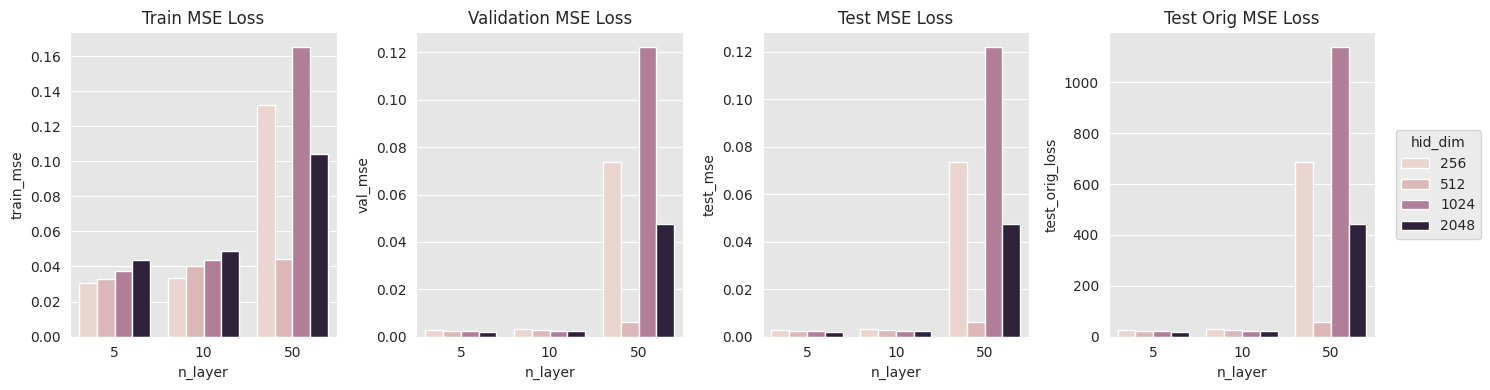

In [ ]:
exp201 = load_exp_result('exp201')
var1 = 'n_layer'
var2 = 'hid_dim'
plot_mse_loss(var1, var2, exp201)

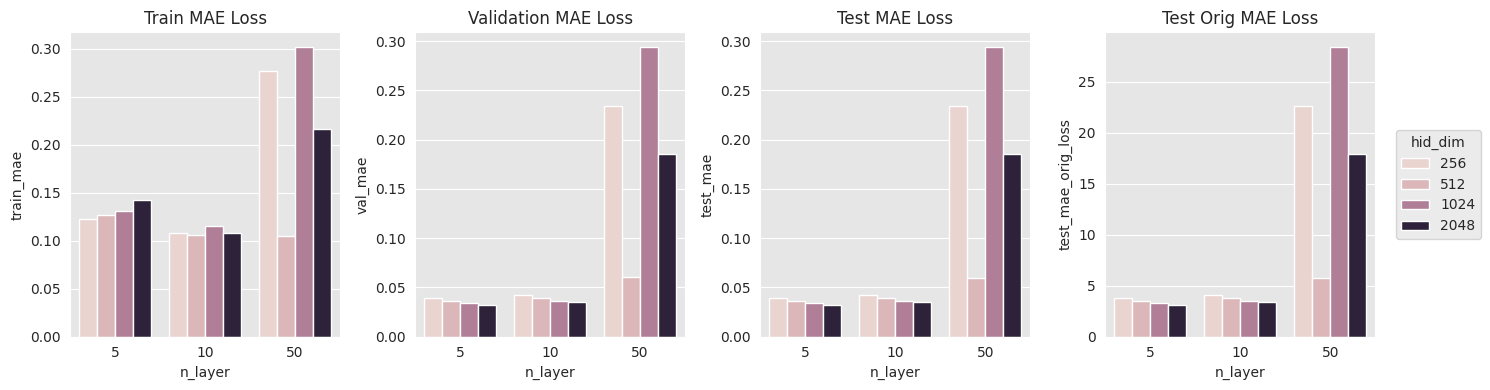

In [ ]:
plot_mae_loss(var1, var2, exp201)

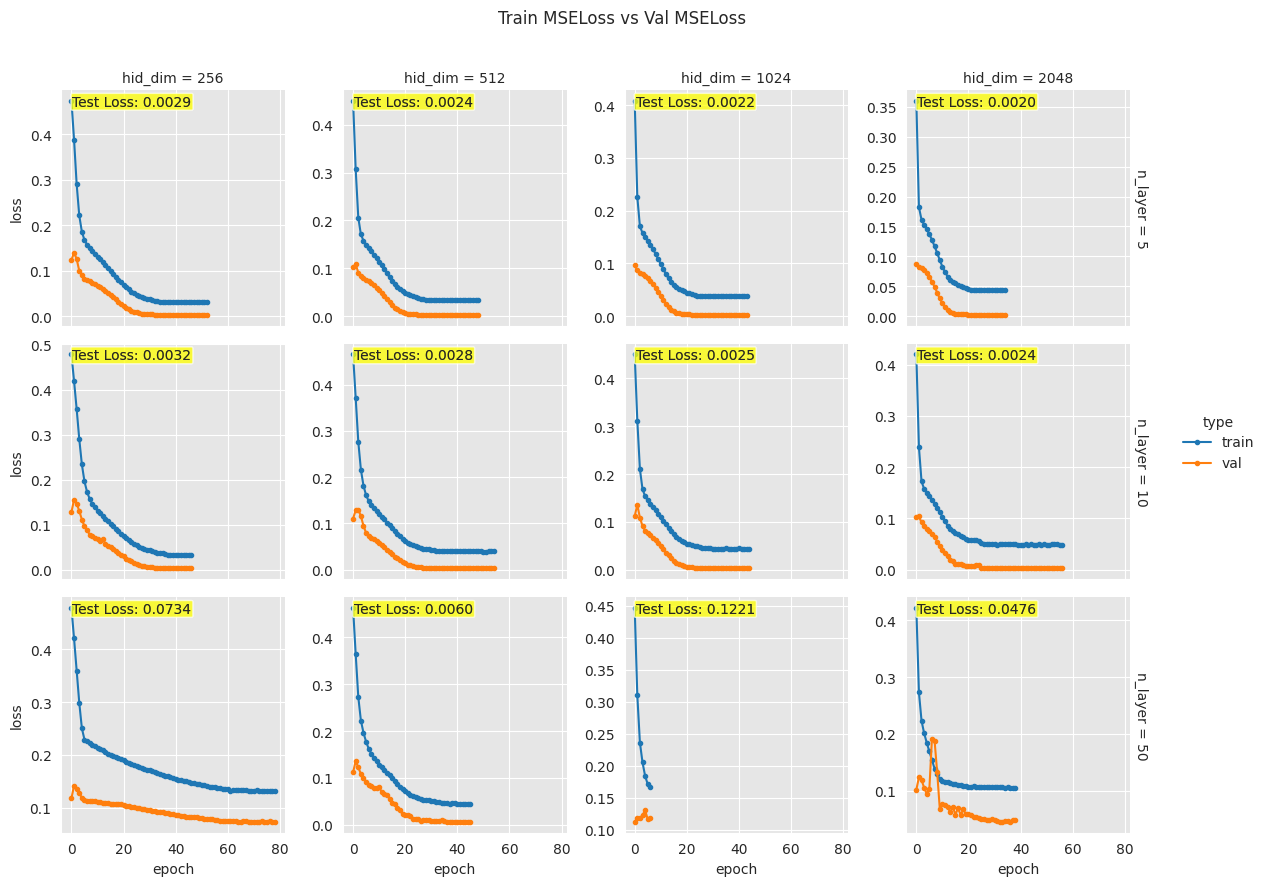

In [ ]:
plot_loss_variation(var2, var1, exp201)

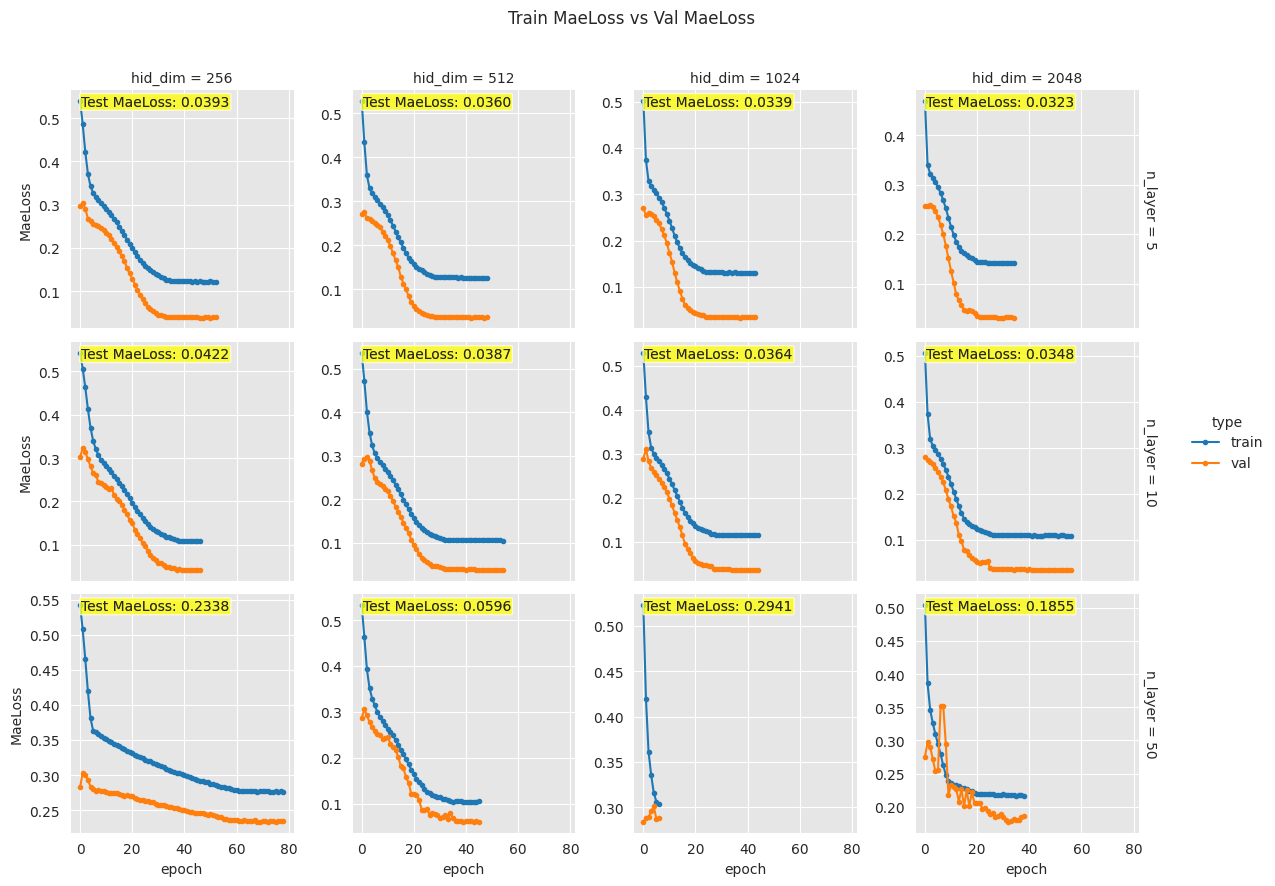

In [ ]:
plot_mae_loss_variation(var2, var1, exp201)

Experiment 202

- model_type : MLP
- Best performance : lr(0.01) / dropout(0.3)

In [ ]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp202_test"

# ====== Model ====== #
args.model_type = 'MLP'
args.n_layer = 5
#args.in_channels = 1
args.out_dim = 304 * 2
args.hid_dim = 2048
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.0001
args.use_bn = True
args.dropout = 0.3

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.01
args.epoch = 100

args.use_early_stopping = True
args.use_scheduler = True

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'dropout'
list_var1 = [0.01, 0.001, 0.0001]
list_var2 = [0.2, 0.3, 0.4]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)

        setting, result = experiment(partition, deepcopy(args))
        hash_key =  save_exp_result(setting, result)

Namespace(exp_name='exp202_test', model_type='MLP', n_layer=5, out_dim=608, hid_dim=2048, act='relu', l2=0.0001, use_bn=True, dropout=0.2, optim='Adam', lr=0.01, epoch=100, use_early_stopping=True, use_scheduler=True, train_batch_size=256, test_batch_size=1024)
Epoch 0, Loss(train/val) 6.2392/46.5860, MAELoss(train/val) 1.5323/5.1393, MAE_origLoss(val) 496.5357. Took 0.95 sec, Current LR 0.010000
Epoch 1, Loss(train/val) 0.7549/0.1159, MAELoss(train/val) 0.6460/0.2390, MAE_origLoss(val) 23.0954. Took 0.85 sec, Current LR 0.010000
Epoch 2, Loss(train/val) 0.5554/0.0819, MAELoss(train/val) 0.5525/0.1973, MAE_origLoss(val) 19.0643. Took 0.86 sec, Current LR 0.010000
Epoch 3, Loss(train/val) 0.4426/0.0590, MAELoss(train/val) 0.4900/0.1828, MAE_origLoss(val) 17.6634. Took 0.88 sec, Current LR 0.010000
Epoch 4, Loss(train/val) 0.3331/0.0543, MAELoss(train/val) 0.4253/0.1812, MAE_origLoss(val) 17.5030. Took 1.17 sec, Current LR 0.010000
Epoch 5, Loss(train/val) 0.3041/0.0802, MAELoss(train/va

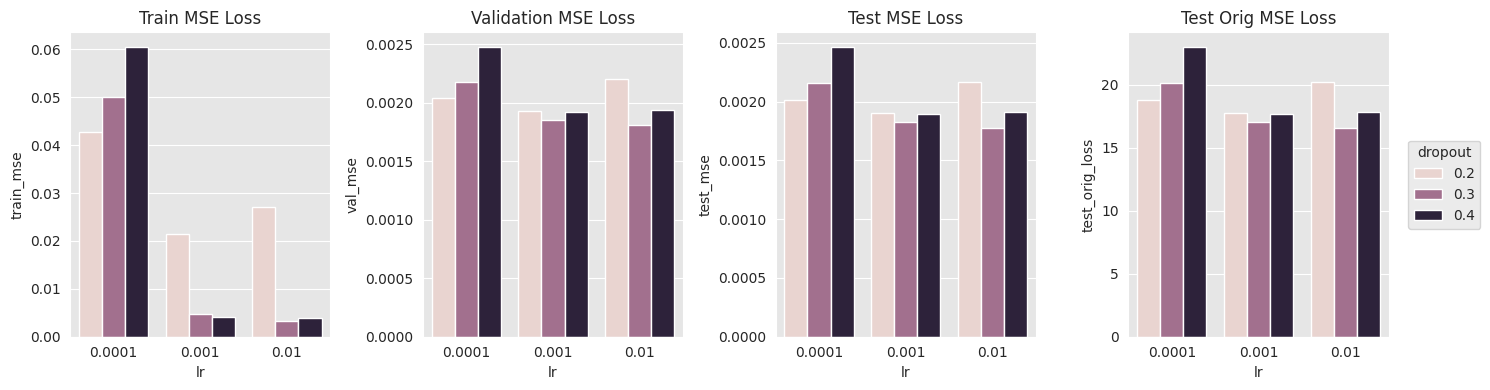

In [ ]:
exp202 = load_exp_result('exp202')
var1 = name_var1
var2 = name_var2
plot_mse_loss(var1, var2, exp202)

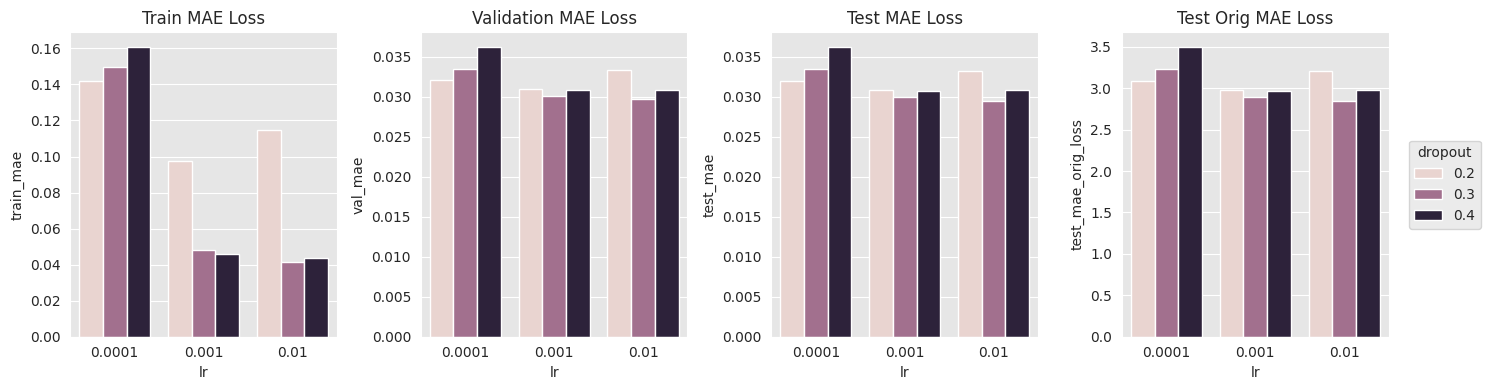

In [ ]:
plot_mae_loss(var1, var2, exp202)

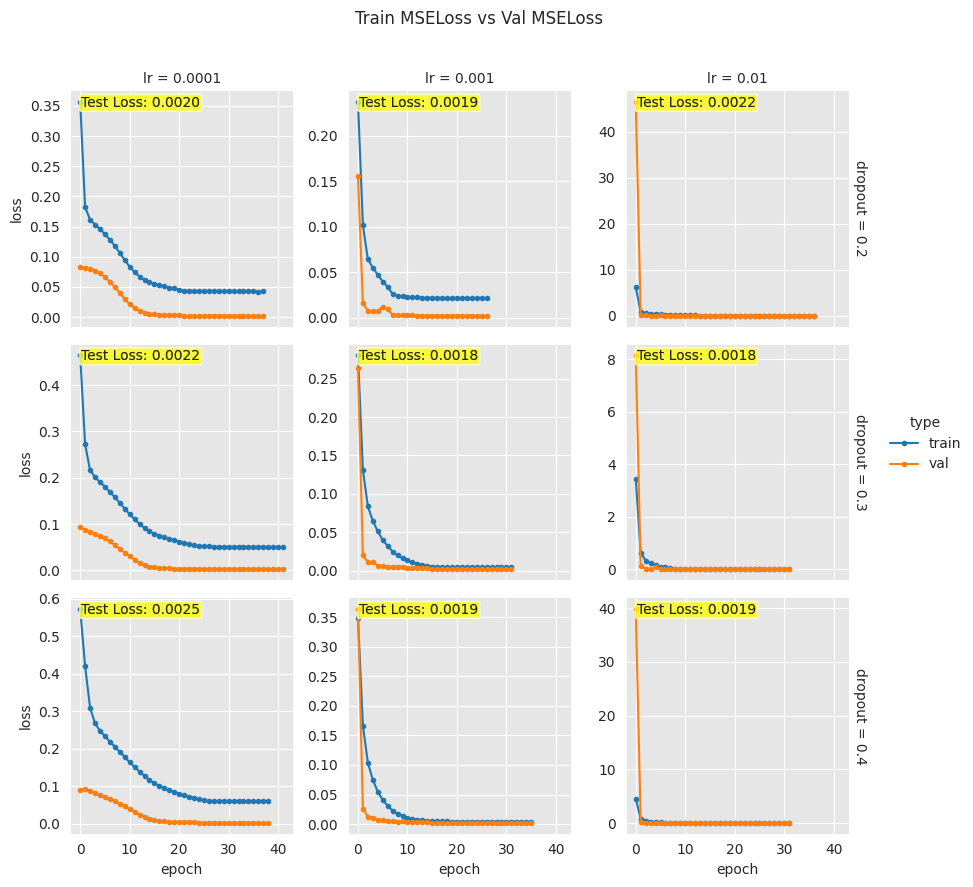

In [ ]:
plot_loss_variation(var1, var2, exp202)

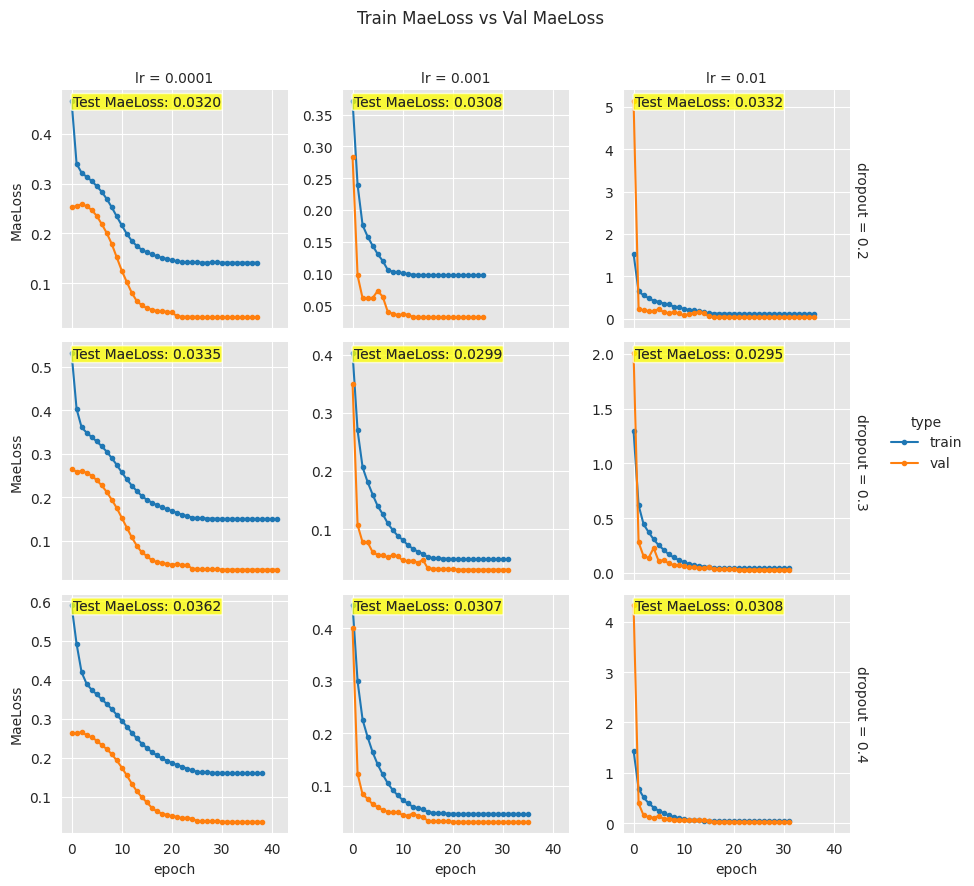

In [ ]:
plot_mae_loss_variation(var1, var2, exp202)

Experiment 203

- model_type : MLP
- Best performance : l2(0.0001) / use_bn(True)

In [ ]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp203_test"

# ====== Model ====== #
args.model_type = 'MLP'
args.n_layer = 5
#args.in_channels = 1
args.out_dim = 304 * 2
args.hid_dim = 2048
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.0001
args.use_bn = True
args.dropout = 0.3

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.01
args.epoch = 100

args.use_early_stopping = True
args.use_scheduler = True

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'l2'
name_var2 = 'use_bn'
list_var1 = [0.01, 0.001, 0.0001, 0.00001]
list_var2 = [True, False]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)

        setting, result = experiment(partition, deepcopy(args))
        hash_key =  save_exp_result(setting, result)

Namespace(exp_name='exp203_test', model_type='MLP', n_layer=5, out_dim=608, hid_dim=2048, act='relu', l2=0.01, use_bn=True, dropout=0.3, optim='Adam', lr=0.01, epoch=100, use_early_stopping=True, use_scheduler=True, train_batch_size=256, test_batch_size=1024)
Epoch 0, Loss(train/val) 4.2861/2.1278, MAELoss(train/val) 1.4215/1.1025, MAE_origLoss(val) 106.5159. Took 0.95 sec, Current LR 0.010000
Epoch 1, Loss(train/val) 0.2889/0.0323, MAELoss(train/val) 0.3828/0.1445, MAE_origLoss(val) 13.9585. Took 0.91 sec, Current LR 0.010000
Epoch 2, Loss(train/val) 0.0381/0.0229, MAELoss(train/val) 0.1514/0.1240, MAE_origLoss(val) 11.9812. Took 0.87 sec, Current LR 0.010000
Epoch 3, Loss(train/val) 0.0213/0.0199, MAELoss(train/val) 0.1250/0.1187, MAE_origLoss(val) 11.4644. Took 1.22 sec, Current LR 0.010000
Epoch 4, Loss(train/val) 0.0209/0.0225, MAELoss(train/val) 0.1258/0.1278, MAE_origLoss(val) 12.3430. Took 1.11 sec, Current LR 0.010000
Epoch 5, Loss(train/val) 0.0196/0.0228, MAELoss(train/val) 

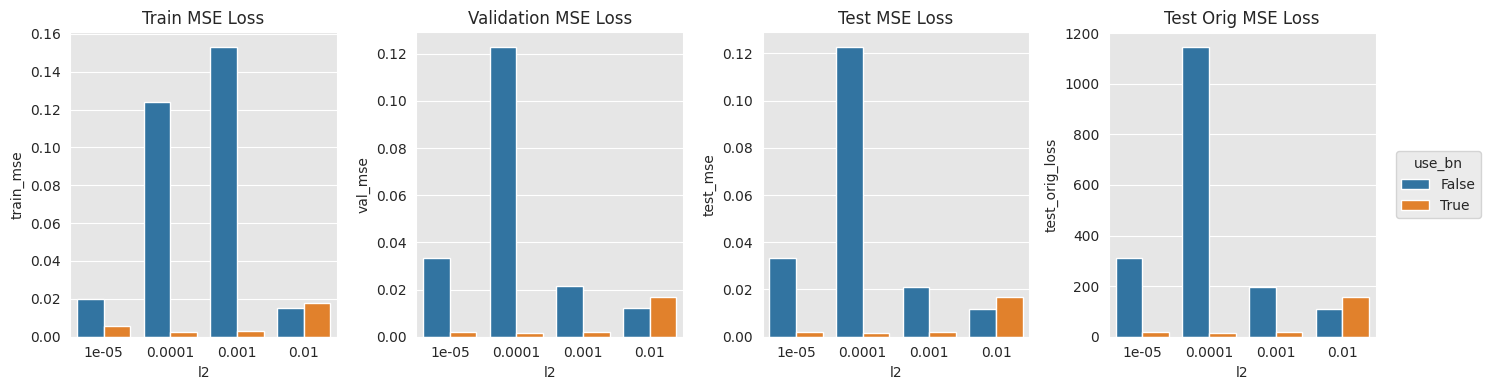

In [ ]:
exp203 = load_exp_result('exp203')
var1 = name_var1
var2 = name_var2
plot_mse_loss(var1, var2, exp203)

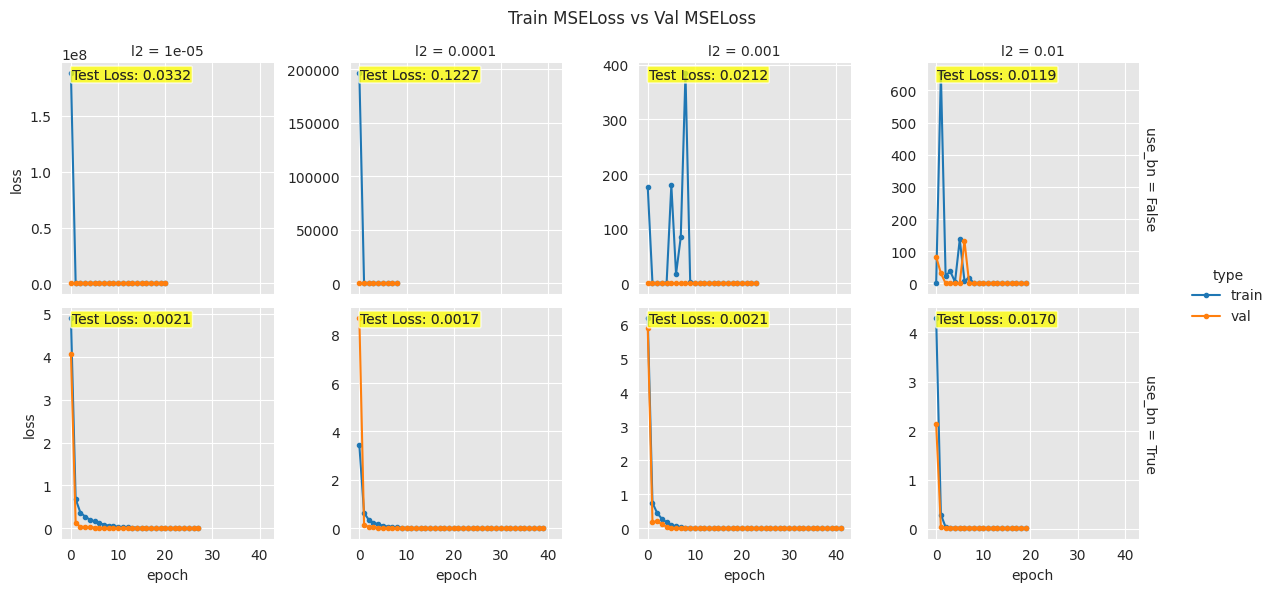

In [ ]:
plot_loss_variation(var1, var2, exp203)

Experiment 204
- model_type : CNN
- Best performance : model_code('Depth2') / hid_dim(256)

In [ ]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp204_test"

# ====== Model ====== #
args.model_type = 'CNN'
args.model_code = 'Depth2'
args.in_channels = 1
args.out_dim = 304 * 2
args.hid_dim = 256
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.1
args.use_bn = True
args.dropout = 0.4

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.001
args.epoch = 100

args.use_early_stopping = True
args.use_scheduler = True

args.train_batch_size = 256
args.test_batch_size = 1024
# ====== Experiment Variable ====== #
name_var1 = 'model_code'
name_var2 = 'hid_dim'
list_var1 = ['Depth1', 'Depth2', 'Depth3', 'Depth4']
list_var2 = [256, 512, 1024, 2048]

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)

        setting, result = experiment(partition, deepcopy(args))
        hash_key =  save_exp_result(setting, result)

Namespace(exp_name='exp204_test', model_type='CNN', model_code='Depth1', in_channels=1, out_dim=608, hid_dim=256, act='relu', l2=0.1, use_bn=True, dropout=0.4, optim='Adam', lr=0.001, epoch=100, use_early_stopping=True, use_scheduler=True, train_batch_size=256, test_batch_size=1024)


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

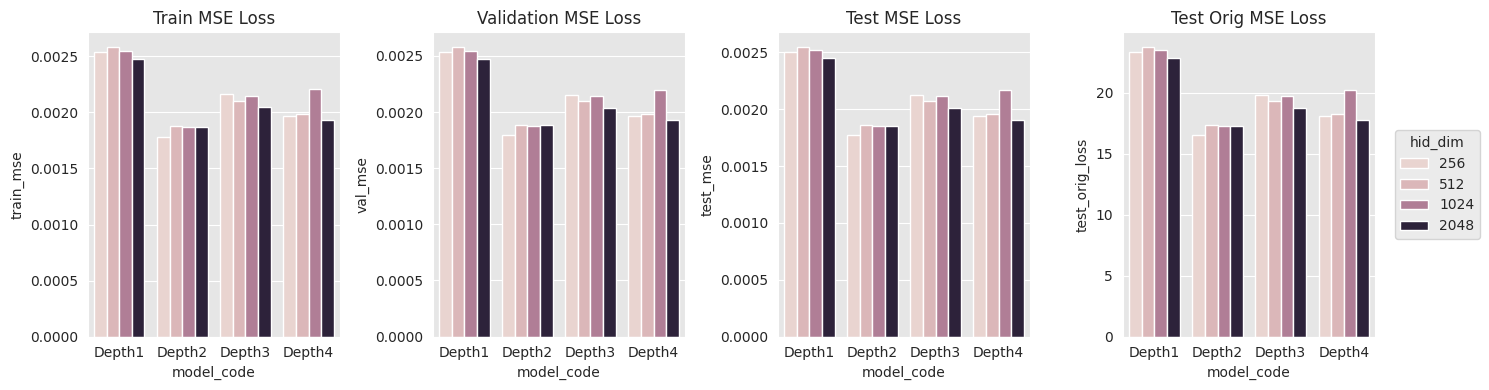

In [ ]:
exp204 = load_exp_result('exp204')
var1 = name_var1
var2 = name_var2
order = ['Depth1', 'Depth2', 'Depth3', 'Depth4']
plot_mse_loss(var1, var2, exp204, order=order)

<Axes: xlabel='model_code', ylabel='test_orig_loss'>

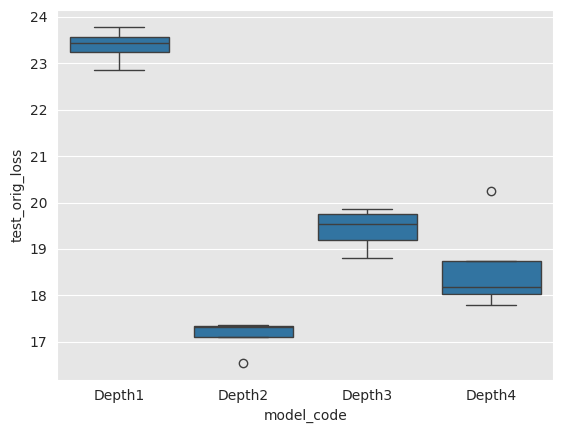

In [ ]:
sns.boxplot(x='model_code', y='test_orig_loss', data=exp204[['test_orig_loss', 'model_code', 'hid_dim']])

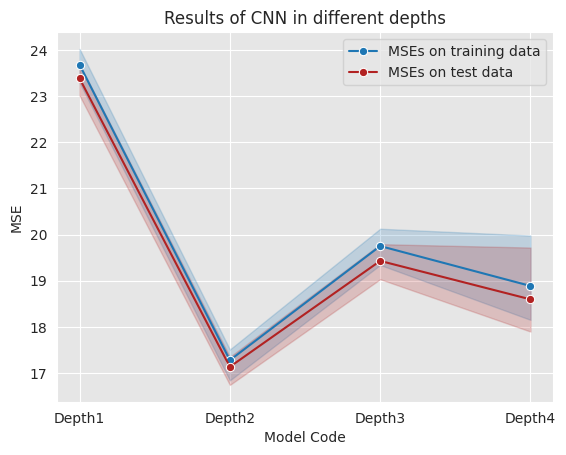

In [ ]:
sns.lineplot(x='model_code', y='train_orig_loss', data=exp204,  label='MSEs on training data', marker ='o')
sns.lineplot(x='model_code', y='test_orig_loss', data=exp204,  label='MSEs on test data', marker = 'o', c = 'firebrick')
plt.legend()
plt.title('Results of CNN in different depths')
plt.xlabel('Model Code')
plt.ylabel('MSE')
plt.show()

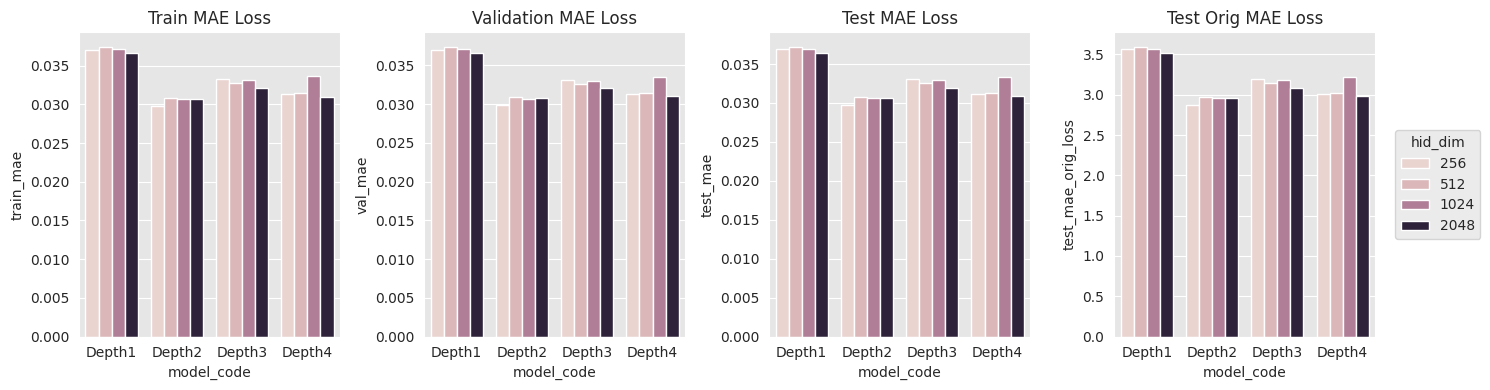

In [ ]:
plot_mae_loss(var1, var2, exp204, order=order)

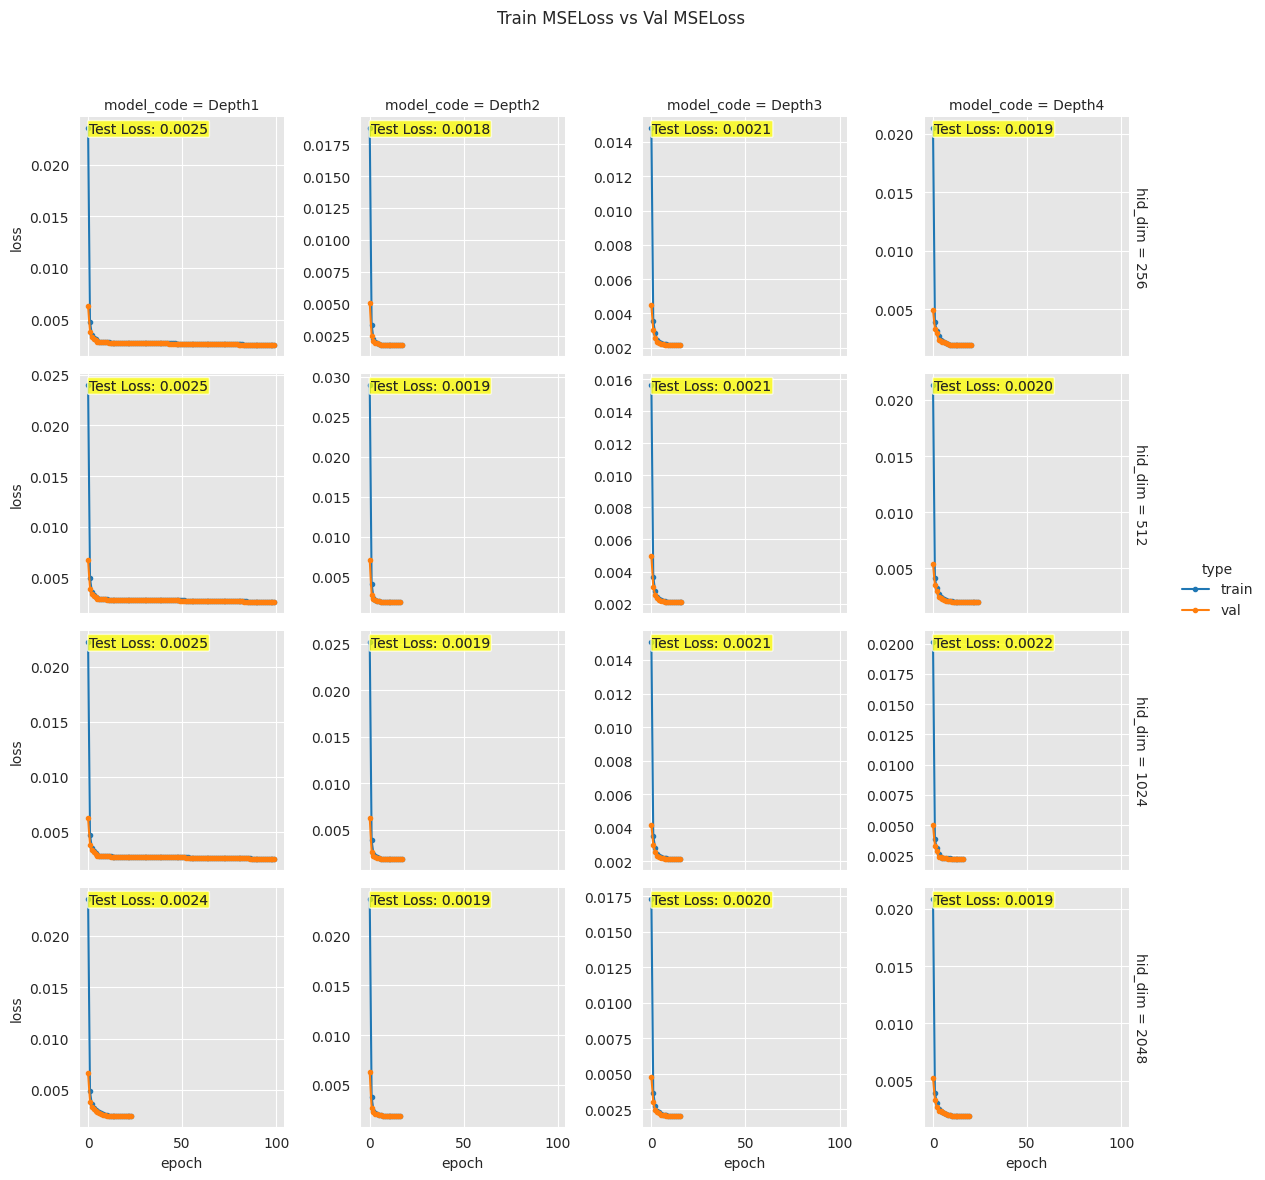

In [ ]:
plot_loss_variation(var1, var2, exp204,  order_var1=order)

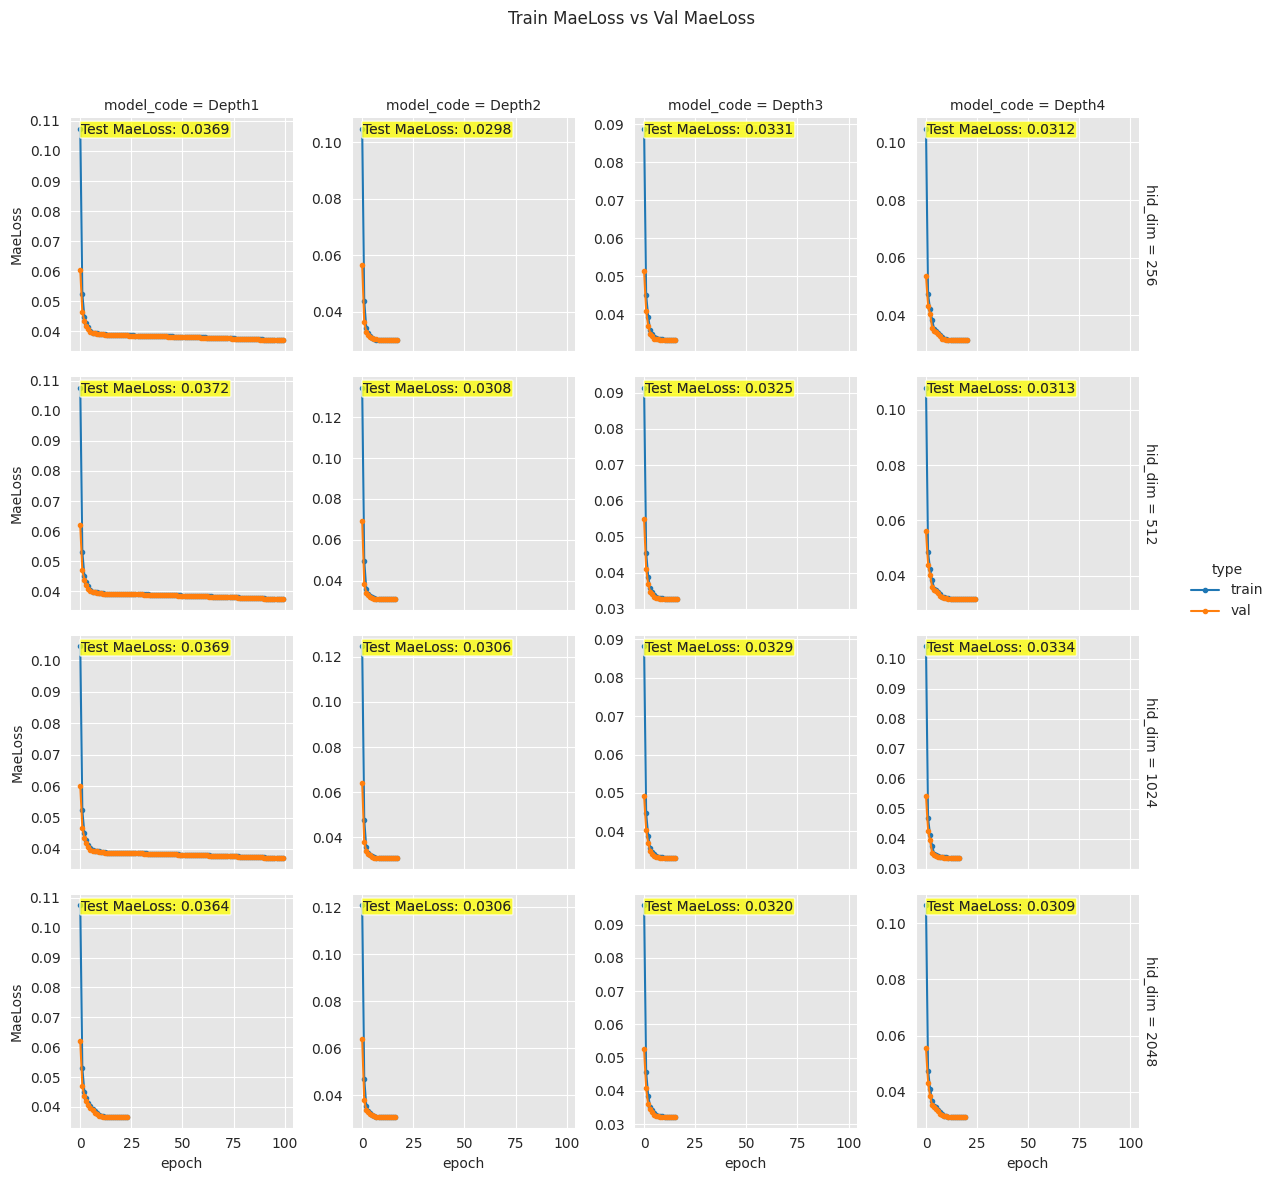

In [ ]:
plot_mae_loss_variation(var1, var2, exp204,  order_var1=order)

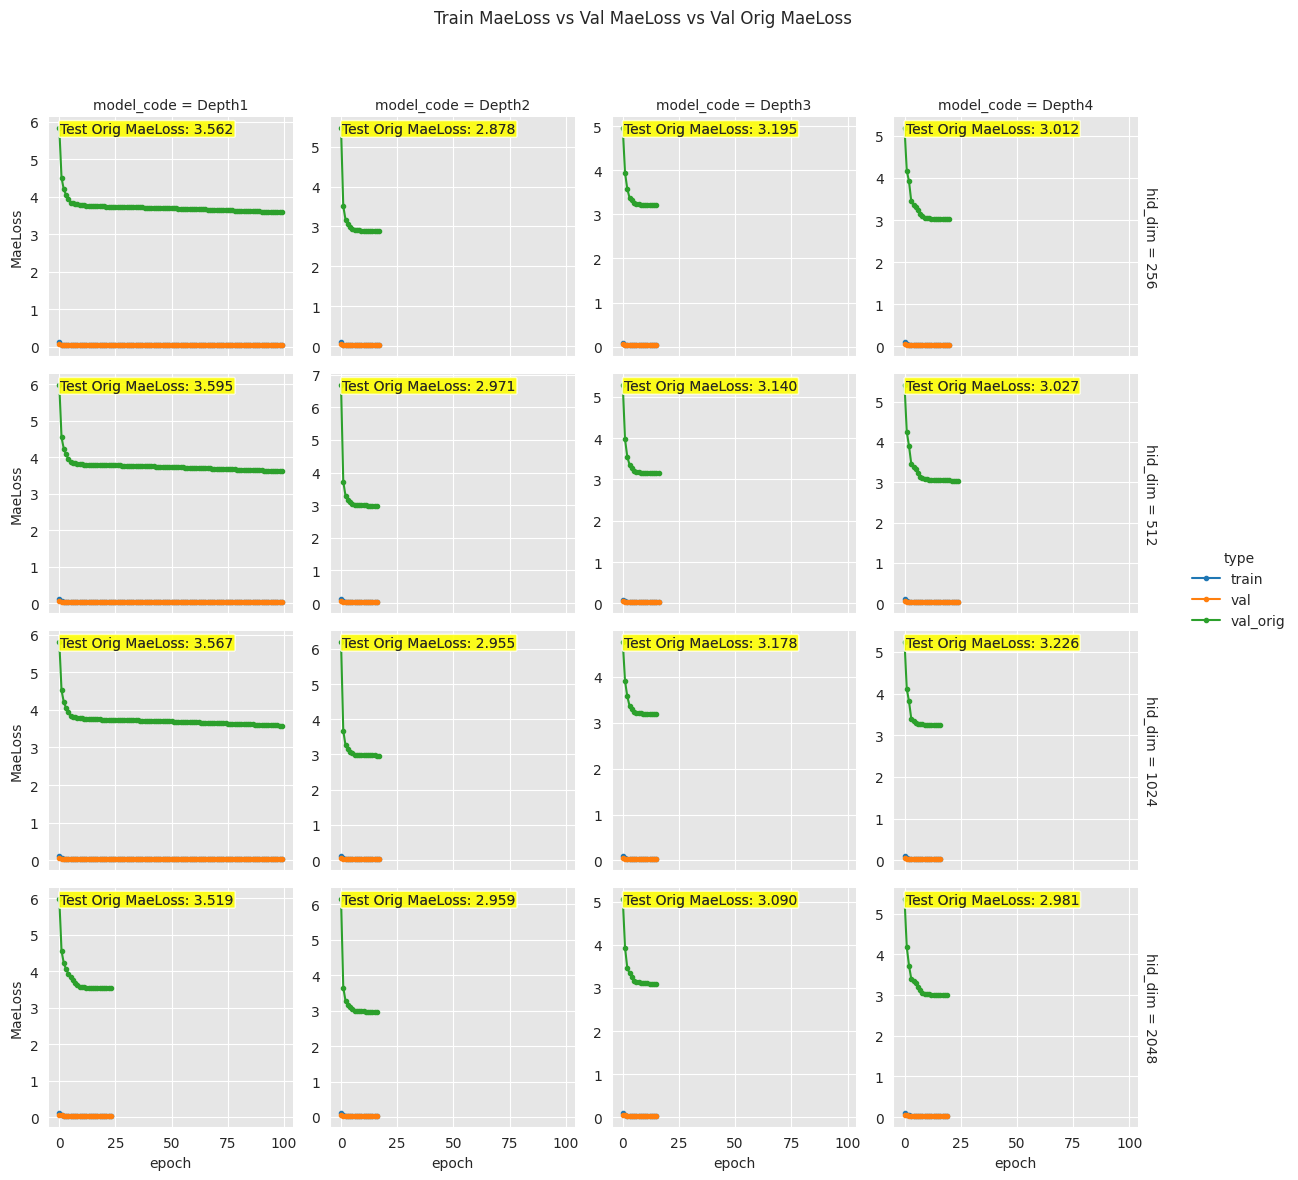

In [ ]:
plot_mae_loss_variation_add(var1, var2, exp204,  order_var1=order)

Experiment 205

model_type : CNN
Best performance : lr(0.001), dropout(0.4)

In [ ]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp205_test"

# ====== Model ====== #
args.model_type = 'CNN'
args.model_code = 'Depth2'
args.in_channels = 1
args.out_dim = 304 * 2
args.hid_dim = 256
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.001
args.use_bn = False
args.dropout = 0.4

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.001
args.epoch = 100

args.use_early_stopping = True
args.use_scheduler = True

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'dropout'
list_var1 = [0.01, 0.001, 0.0001]
list_var2 = [0.2, 0.3, 0.4]

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)

        setting, result = experiment(partition, deepcopy(args))
        hash_key =  save_exp_result(setting, result)

Namespace(exp_name='exp205_test', model_type='CNN', model_code='Depth2', in_channels=1, out_dim=608, hid_dim=256, act='relu', l2=0.001, use_bn=False, dropout=0.2, optim='Adam', lr=0.01, epoch=100, use_early_stopping=True, use_scheduler=True, train_batch_size=256, test_batch_size=1024)
Epoch 0, Loss(train/val) 233.1704/2.1214, MAELoss(train/val) 9.7773/1.3316, MAE_origLoss(val) 128.6569. Took 1.39 sec, Current LR 0.010000
Epoch 1, Loss(train/val) 0.4302/0.0982, MAELoss(train/val) 0.4591/0.2443, MAE_origLoss(val) 23.6009. Took 1.20 sec, Current LR 0.010000
Epoch 2, Loss(train/val) 0.0638/0.0384, MAELoss(train/val) 0.1972/0.1534, MAE_origLoss(val) 14.8189. Took 1.18 sec, Current LR 0.010000
Epoch 3, Loss(train/val) 0.0251/0.0284, MAELoss(train/val) 0.1180/0.1152, MAE_origLoss(val) 11.1287. Took 1.21 sec, Current LR 0.010000
Epoch 4, Loss(train/val) 0.0191/0.0183, MAELoss(train/val) 0.1007/0.0874, MAE_origLoss(val) 8.4476. Took 1.21 sec, Current LR 0.010000
Epoch 5, Loss(train/val) 0.0139/

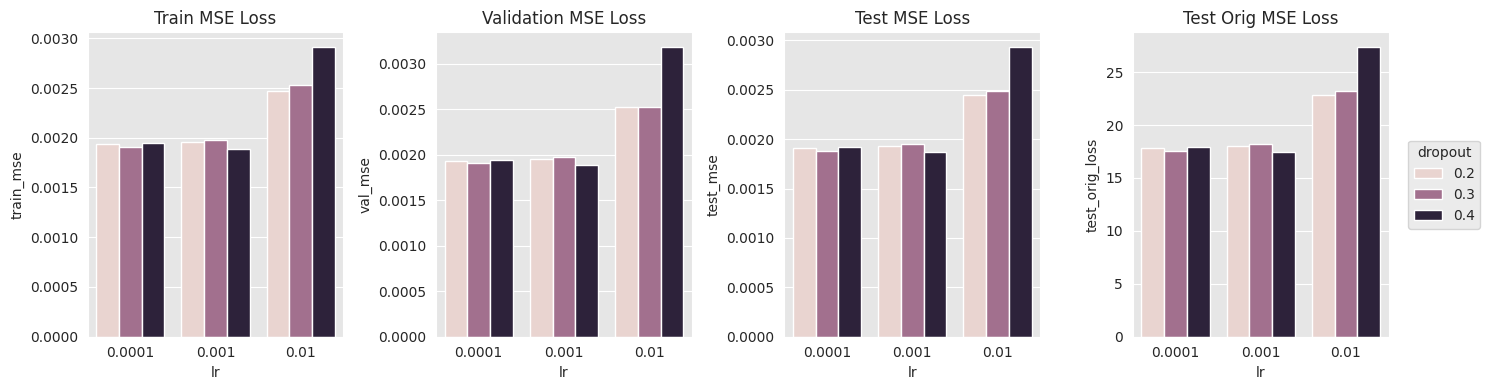

In [ ]:
exp205 = load_exp_result('exp205')
var1 = 'lr'
var2 = 'dropout'

plot_mse_loss(var1, var2, exp205)

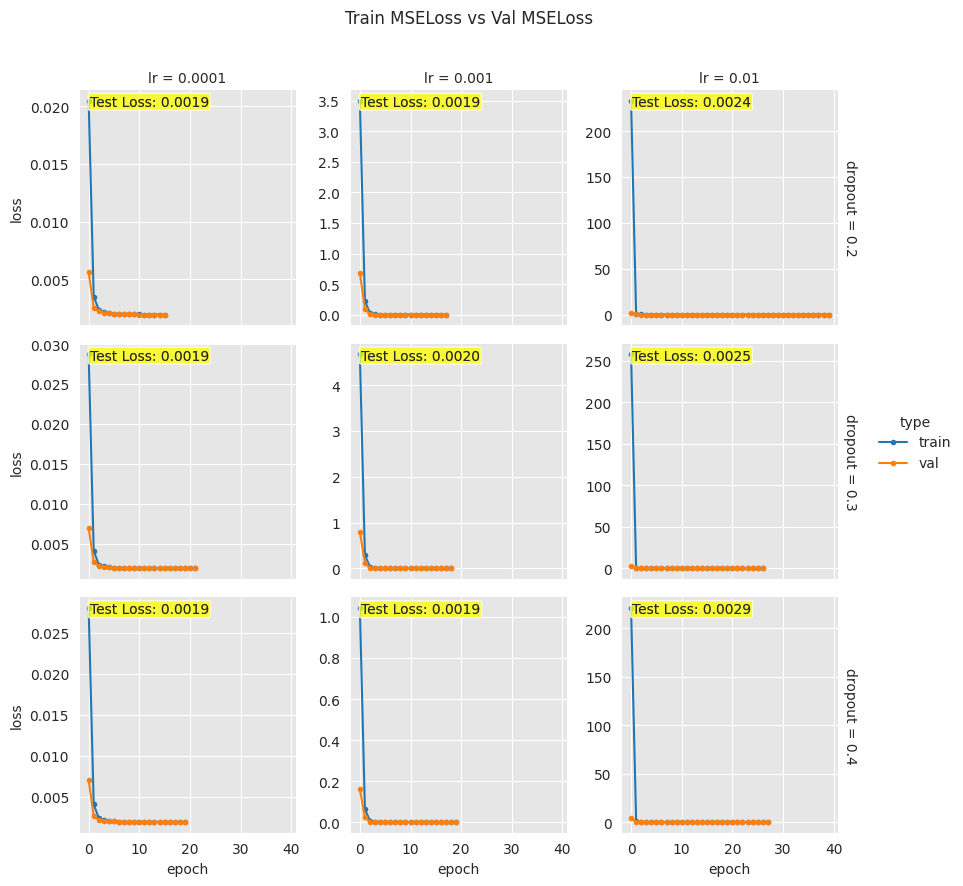

In [ ]:
plot_loss_variation(var1, var2, exp205)

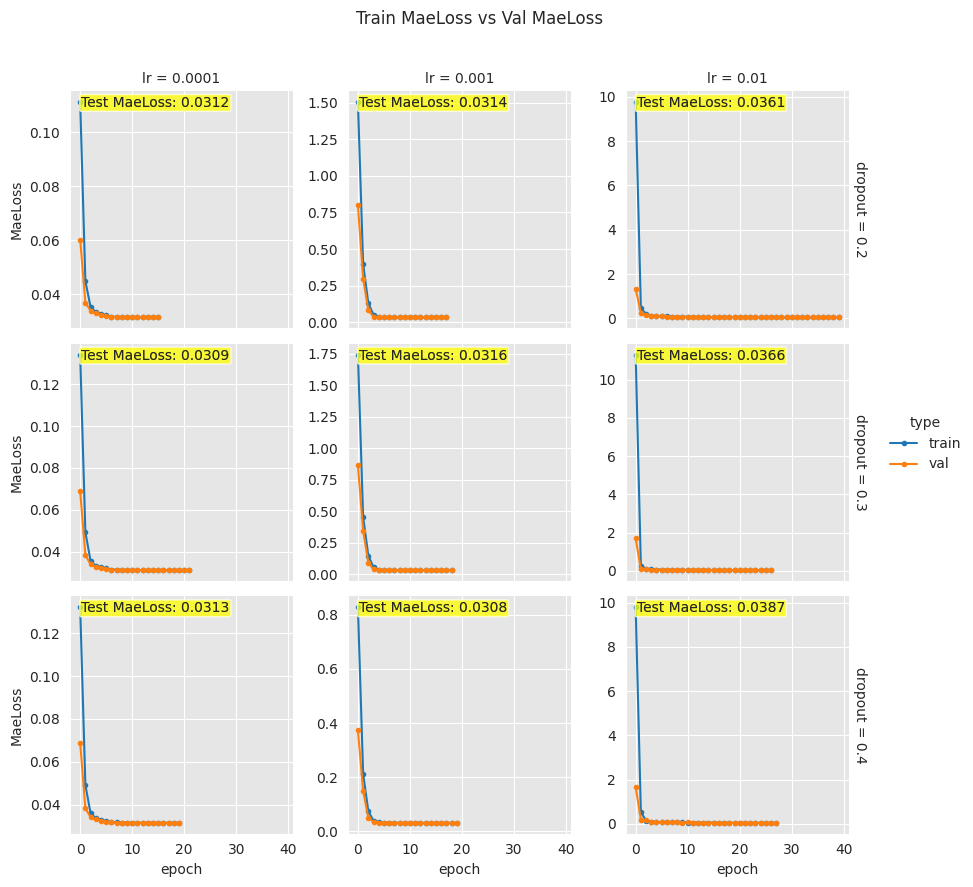

In [ ]:
plot_mae_loss_variation(var1, var2, exp205)

Experiment 206

model_type : CNN
Best performance : l2(0.1) / use_bn(True)

In [ ]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp206_test"

# ====== Model ====== #
args.model_type = 'CNN'
args.model_code = 'Depth2'
args.in_channels = 1
args.out_dim = 304 * 2
args.hid_dim = 256
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.1
args.use_bn = True
args.dropout = 0.4

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.001
args.epoch = 100

args.use_early_stopping = True
args.use_scheduler = True

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'l2'
name_var2 = 'use_bn'
list_var1 = [0.1, 0.01, 0.001, 0.0001]
list_var2 = [True, False]

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)

        setting, result = experiment(partition, deepcopy(args))
        hash_key =  save_exp_result(setting, result)

Namespace(exp_name='exp206_test', model_type='CNN', model_code='Depth2', in_channels=1, out_dim=608, hid_dim=256, act='relu', l2=0.1, use_bn=True, dropout=0.4, optim='Adam', lr=0.001, epoch=100, use_early_stopping=True, use_scheduler=True, train_batch_size=256, test_batch_size=1024)
Epoch 0, Loss(train/val) 116.0847/0.3521, MAELoss(train/val) 8.6379/0.4469, MAE_origLoss(val) 43.1784. Took 2.70 sec, Current LR 0.001000
Epoch 1, Loss(train/val) 8.2379/0.7603, MAELoss(train/val) 2.4138/0.8108, MAE_origLoss(val) 78.3342. Took 1.25 sec, Current LR 0.001000
Epoch 2, Loss(train/val) 0.8541/0.0799, MAELoss(train/val) 0.7775/0.2320, MAE_origLoss(val) 22.4155. Took 1.26 sec, Current LR 0.001000
Epoch 3, Loss(train/val) 0.0766/0.0172, MAELoss(train/val) 0.2271/0.1038, MAE_origLoss(val) 10.0297. Took 1.60 sec, Current LR 0.001000
Epoch 4, Loss(train/val) 0.0144/0.0100, MAELoss(train/val) 0.0944/0.0787, MAE_origLoss(val) 7.6026. Took 1.33 sec, Current LR 0.001000
Epoch 5, Loss(train/val) 0.0071/0.0

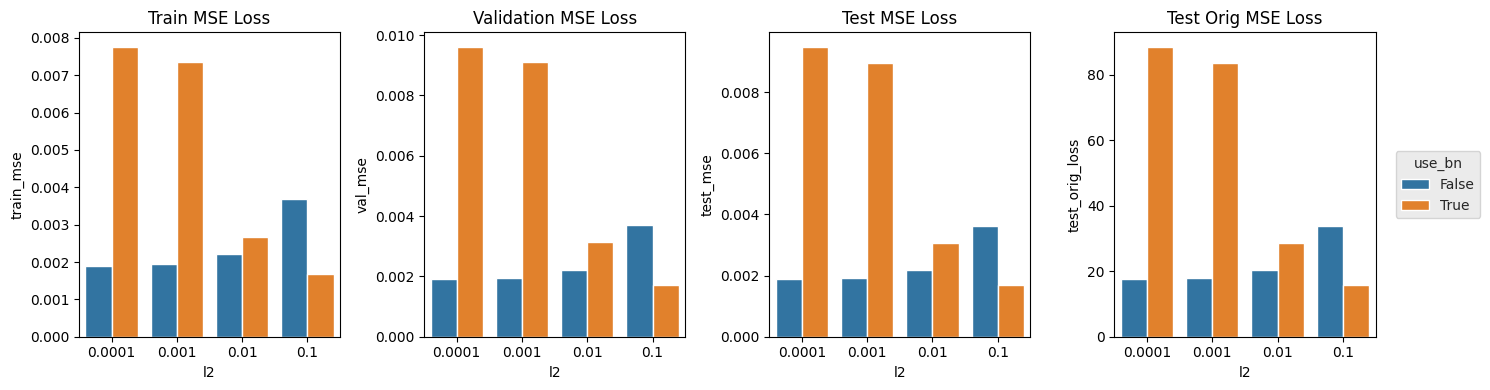

In [ ]:
exp206 = load_exp_result('exp206')
var1 = name_var1
var2 = name_var2

plot_mse_loss(var1, var2, exp206)

In [ ]:
exp206

train_losses  \
0  [130.2893460470603, 9.023071176256689, 0.94233...   
1  [1.4919699702490208, 0.09365702479549876, 0.01...   
2  [3.607976691925334, 0.22155888054622874, 0.024...   
3  [126.5054389525478, 8.701178339010752, 0.87743...   
4  [3.670451678891901, 0.22093795843519845, 0.024...   
5  [116.08472510099293, 8.237850064799952, 0.8540...   
6  [0.3585441972005251, 0.025240230798922347, 0.0...   
7  [125.2687020556774, 8.567911666358391, 0.86285...   

                                          val_losses  \
0  [0.49106189608573914, 0.4022488296031952, 0.19...   
1  [0.21633368730545044, 0.0365583710372448, 0.00...   
2  [0.6347223520278931, 0.09361504763364792, 0.00...   
3  [0.47166311740875244, 0.43612542748451233, 0.1...   
4  [0.5124446749687195, 0.09613167494535446, 0.00...   
5  [0.3521452248096466, 0.7603384256362915, 0.079...   
6  [0.06461513787508011, 0.007681533228605986, 0....   
7  [0.5051396489143372, 0.40102753043174744, 0.16...   

                                    train_mae_losses  \
0  [9.201535363995344, 2.5670188792670254, 0.8151...   
1  [0.9900866393773805, 0.259814855138645, 0.0871...   
2  [1.5352417534105314, 0.4010172294003544, 0.130...   
3  [9.075450812363306, 2.519594677334056, 0.78658...   
4  [1.5445612041469916, 0.40111321638582004, 0.12...   
5  [8.637944037660505, 2.4137544409957594, 0.7774...   
6  [0.46282282809837433, 0.1281994701053425, 0.05...   
7  [9.024401052920476, 2.4955310187894684, 0.7802...   

                                      val_mae_losses  \
0  [0.602957546710968, 0.5107487440109253, 0.3948...   
1  [0.43416500091552734, 0.1797550916671753, 0.05...   
2  [0.7701218724250793, 0.2973252236843109, 0.082...   
3  [0.5775497555732727, 0.5425868034362793, 0.378...   
4  [0.692123293876648, 0.29885098338127136, 0.078...   
5  [0.44690006971359253, 0.8107988834381104, 0.23...   
6  [0.2166406810283661, 0.07081213593482971, 0.04...   
7  [0.6033942103385925, 0.5219303965568542, 0.357...   

                                 val_mae_orig_losses  train_mse   val_mse  \
0  [58.2535400390625, 49.3454475402832, 38.146018...   0.002657  0.003133   
1  [41.94668197631836, 17.366891860961914, 5.3803...   0.001939  0.001939   
2  [74.40473937988281, 28.725906372070312, 7.9914...   0.001896  0.001901   
3  [55.79906463623047, 52.423133850097656, 36.609...   0.007762  0.009612   
4  [66.86897277832031, 28.87346076965332, 7.61372...   0.002224  0.002216   
5  [43.17844009399414, 78.33418273925781, 22.4155...   0.001682  0.001718   
6  [20.931726455688477, 6.8416547775268555, 4.573...   0.003698  0.003690   
7  [58.29634094238281, 50.426483154296875, 34.495...   0.007354  0.009096   

   test_mse  train_mae   val_mae  ...      l2  use_bn  dropout  optim     lr  \
0  0.003064   0.039980  0.043094  ...  0.0100    True      0.4   Adam  0.001   
1  0.001915   0.031404  0.031396  ...  0.0010   False      0.4   Adam  0.001   
2  0.001875   0.031074  0.031098  ...  0.0001   False      0.4   Adam  0.001   
3  0.009486   0.069365  0.076436  ...  0.0001    True      0.4   Adam  0.001   
4  0.002186   0.033958  0.033876  ...  0.0100   False      0.4   Adam  0.001   
5  0.001692   0.029641  0.029945  ...  0.1000    True      0.4   Adam  0.001   
6  0.003618   0.045790  0.045737  ...  0.1000   False      0.4   Adam  0.001   
7  0.008949   0.067428  0.074410  ...  0.0010    True      0.4   Adam  0.001   

  use_early_stopping use_scheduler train_batch_size  test_batch_size  hash_key  
0               True          True              256             1024    4e5c4b  
1               True          True              256             1024    de4a63  
2               True          True              256             1024    3b2d58  
3               True          True              256             1024    54a3da  
4               True          True              256             1024    8b81f8  
5               True          True              256             1024    6aaed2  
6               True          True    

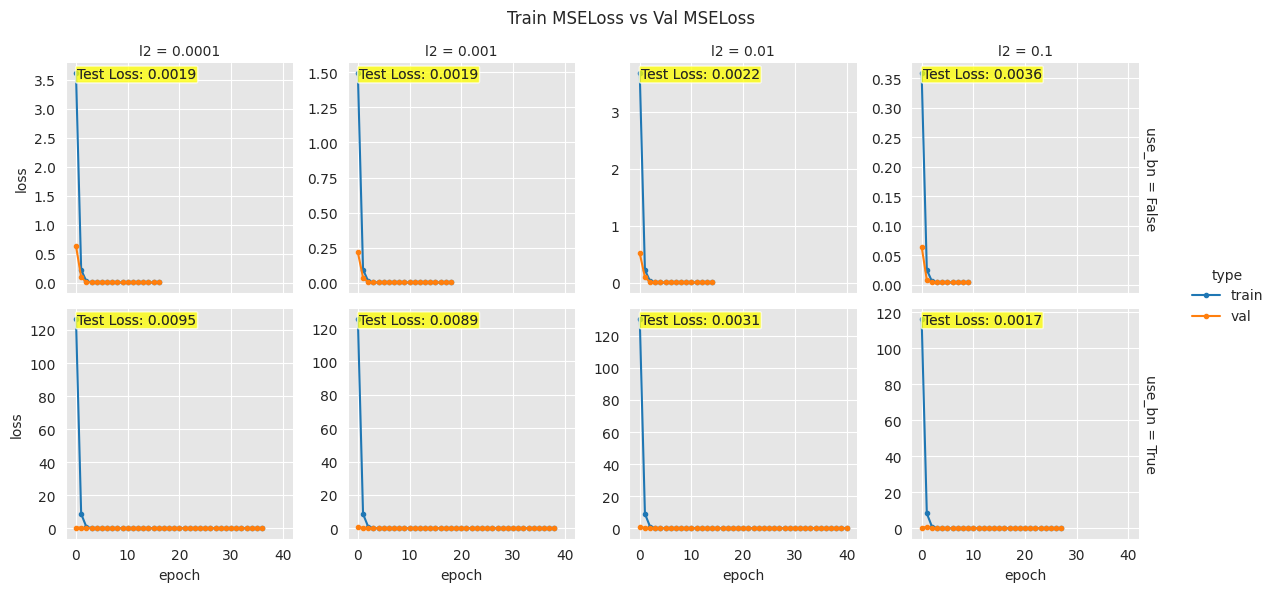

In [ ]:
plot_loss_variation(var1, var2, exp206)

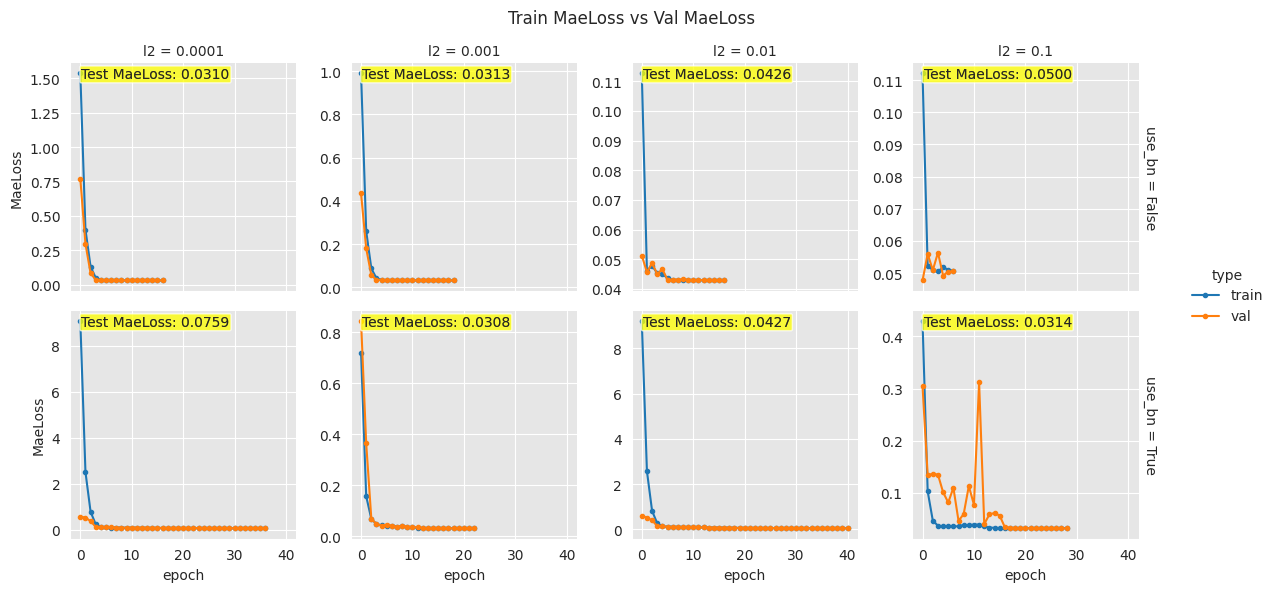

In [ ]:
plot_mae_loss_variation(var1, var2, exp206)

Best MLP VS Best CNN

In [ ]:
# ====== Random Seed Initialization ====== #
set_seed(42)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp203_test"

# ====== Model ====== #
args.model_type = 'MLP'
args.n_layer = 5
#args.in_channels = 1
args.out_dim = 304 * 2
args.hid_dim = 2048
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.0001
args.use_bn = True
args.dropout = 0.3

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.01
args.epoch = 100

args.use_early_stopping = True
args.use_scheduler = True

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'l2'
name_var2 = 'use_bn'
list_var1 = [ 0.0001]
list_var2 = [True]


for var1 in list_var1:
    for var2 in list_var2:
        set_seed(42)
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)

        setting, result = experiment(partition, deepcopy(args))
        hash_key =  save_exp_result(setting, result)

Namespace(exp_name='exp203_test', model_type='MLP', n_layer=5, out_dim=608, hid_dim=2048, act='relu', l2=0.0001, use_bn=True, dropout=0.3, optim='Adam', lr=0.01, epoch=100, use_early_stopping=True, use_scheduler=True, train_batch_size=256, test_batch_size=1024)
Epoch 0, Loss(train/val) 4.4035/2.5469, MAELoss(train/val) 1.4193/1.0299, MAE_origLoss(val) 99.5047. Took 1.26 sec, Current LR 0.010000
Epoch 1, Loss(train/val) 0.6146/0.1756, MAELoss(train/val) 0.5486/0.2784, MAE_origLoss(val) 26.8982. Took 1.15 sec, Current LR 0.010000
Epoch 2, Loss(train/val) 0.3135/0.0517, MAELoss(train/val) 0.3980/0.1570, MAE_origLoss(val) 15.1727. Took 1.13 sec, Current LR 0.010000
Epoch 3, Loss(train/val) 0.2413/0.0455, MAELoss(train/val) 0.3503/0.1513, MAE_origLoss(val) 14.6204. Took 0.87 sec, Current LR 0.010000
Epoch 4, Loss(train/val) 0.1781/0.0265, MAELoss(train/val) 0.3004/0.1196, MAE_origLoss(val) 11.5552. Took 0.86 sec, Current LR 0.010000
Epoch 5, Loss(train/val) 0.1317/0.0286, MAELoss(train/val)

In [ ]:
result_concat = pd.concat([exp203.loc[exp203['test_mse'].idxmin()], exp206.loc[exp206['test_mse'].idxmin()]], axis=1)
result_concat.T

train_losses  \
0  [3.4224486553674898, 0.634775242087581, 0.3503...   
5  [116.08472510099293, 8.237850064799952, 0.8540...   

                                          val_losses  \
0  [8.672114372253418, 0.13292571902275085, 0.054...   
5  [0.3521452248096466, 0.7603384256362915, 0.079...   

                                    train_mae_losses  \
0  [1.2887505249281708, 0.6188124165079527, 0.458...   
5  [8.637944037660505, 2.4137544409957594, 0.7774...   

                                      val_mae_losses  \
0  [2.029291868209839, 0.29953673481941223, 0.191...   
5  [0.44690006971359253, 0.8107988834381104, 0.23...   

                                 val_mae_orig_losses train_mse   val_mse  \
0  [196.06057739257812, 28.939611434936523, 18.52...  0.002527  0.001731   
5  [43.17844009399414, 78.33418273925781, 22.4155...  0.001682  0.001718   

   test_mse train_mae   val_mae  ... dropout optim     lr use_early_stopping  \
0  0.001704  0.036733  0.028811  ...     0.3  Adam   0.01               True   
5  0.001692  0.029641  0.029945  ...     0.4  Adam  0.001               True   

  use_scheduler train_batch_size test_batch_size hash_key model_code  \
0          True              256            1024   5bf244        NaN   
5          True              256            1024   6aaed2     Depth2   

  in_channels  
0         NaN  
5           1  

[2 rows x 33 columns]

In [ ]:
exp206

train_losses  \
0  [0.04621070594707357, 0.008056385858479917, 0....   
1  [0.020917386851034364, 0.003954273853987515, 0...   
2  [0.08122161308269867, 0.017528896514256032, 0....   
3  [0.04617739964490536, 0.007863728747485914, 0....   
4  [0.04405939446503512, 0.00690045706746476, 0.0...   
5  [0.025159685328285823, 0.004160912539637275, 0...   
6  [0.04051579743225366, 0.007976284449184065, 0....   
7  [0.020472872819294552, 0.003977704952507804, 0...   

                                          val_losses  \
0  [0.051644228398799896, 0.012204000726342201, 0...   
1  [0.00538090942427516, 0.0033305163960903883, 0...   
2  [0.05698438733816147, 0.006643273402005434, 0....   
3  [0.05375877767801285, 0.011967414990067482, 0....   
4  [0.04190072789788246, 0.01159161701798439, 0.0...   
5  [0.004483900032937527, 0.0036144526675343513, ...   
6  [0.05640946701169014, 0.023100944235920906, 0....   
7  [0.005212771240621805, 0.003509129863232374, 0...   

                                    train_mae_losses  \
0  [0.15551711533306806, 0.06945972460460986, 0.0...   
1  [0.10634028874590506, 0.04765993379274754, 0.0...   
2  [0.26113628478777207, 0.09852364971096637, 0.0...   
3  [0.15537324746951345, 0.06867406611370737, 0.0...   
4  [0.15022758073565817, 0.06394928487002642, 0.0...   
5  [0.11891756692746779, 0.04899806679318804, 0.0...   
6  [0.14400291594818043, 0.06924066444751917, 0.0...   
7  [0.1050939973344463, 0.04775996682396138, 0.04...   

                                      val_mae_losses  \
0  [0.18037942051887512, 0.08726615458726883, 0.0...   
1  [0.05676458775997162, 0.04305427893996239, 0.0...   
2  [0.21533168852329254, 0.06394181400537491, 0.0...   
3  [0.1857662945985794, 0.08641853928565979, 0.04...   
4  [0.1633160263299942, 0.0852963849902153, 0.046...   
5  [0.05135653540492058, 0.04514683410525322, 0.0...   
6  [0.19834674894809723, 0.12611398100852966, 0.0...   
7  [0.05516403540968895, 0.04433995112776756, 0.0...   

                                 val_mae_orig_losses  train_mse   val_mse  \
0  [17.428131103515625, 8.431299209594727, 4.8273...   0.002131  0.002157   
1  [5.484297275543213, 4.159682273864746, 3.77740...   0.001862  0.001861   
2  [20.80416488647461, 6.177737712860107, 4.91423...   0.004172  0.004163   
3  [17.948076248168945, 8.349370956420898, 4.6348...   0.002064  0.002081   
4  [15.777874946594238, 8.240781784057617, 4.5337...   0.001915  0.001919   
5  [4.961811542510986, 4.361849784851074, 4.28312...   0.003179  0.003185   
6  [19.163095474243164, 12.184528350830078, 6.981...   0.001800  0.001783   
7  [5.32968282699585, 4.283903121948242, 4.026452...   0.002233  0.002220   

   test_mse  train_mae   val_mae  ...      l2  use_bn  dropout  optim      lr  \
0  0.002129   0.033974  0.034216  ...  0.0001    True      0.2   Adam  0.0001   
1  0.001838   0.030295  0.030291  ...  0.0001   False      0.2   Adam  0.0001   
2  0.004085   0.049105  0.049042  ...  0.1000   False      0.2   Adam  0.0001   
3  0.002047   0.033206  0.033330  ...  0.0010    True      0.2   Adam  0.0001   
4  0.001892   0.031402  0.031412  ...  0.0100    True      0.2   Adam  0.0001   
5  0.003129   0.042066  0.042153  ...  0.0100   False      0.2   Adam  0.0001   
6  0.001761   0.030045  0.029872  ...  0.1000    True      0.2   Adam  0.0001   
7  0.002193   0.033973  0.033847  ...  0.0010   False      0.2   Adam  0.0001   

  use_early_stopping use_scheduler train_batch_size  test_batch_size  hash_key  
0               True          True              256             1024    40d8ec  
1               True          True              256             1024    7f9bf6  
2               True          True              256             1024    1af6af  
3               True          True              256             1024    a6e351  
4               True          True              256             1024    df820b  
5               True          True              256             1024    c850f2  
6               True         

In [ ]:
exp206.loc[exp206['test_mse'].idxmin()]

train_losses           [0.04051579743225366, 0.007976284449184065, 0....
val_losses             [0.05640946701169014, 0.023100944235920906, 0....
train_mae_losses       [0.14400291594818043, 0.06924066444751917, 0.0...
val_mae_losses         [0.19834674894809723, 0.12611398100852966, 0.0...
val_mae_orig_losses    [19.163095474243164, 12.184528350830078, 6.981...
train_mse                                                         0.0018
val_mse                                                         0.001783
test_mse                                                        0.001761
train_mae                                                       0.030045
val_mae                                                         0.029872
test_mae                                                        0.029763
train_orig_loss                                                16.803725
test_orig_loss                                                 16.440091
val_mae_orig_loss                                               2.886087
test_mae_orig_loss                                              2.875531
exp_name                                                     exp206_test
model_type                                                           CNN
model_code                                                        Depth4
in_channels                                                            1
out_dim                                                              608
hid_dim                                                             2048
act                                                                 relu
l2                                                                   0.1
use_bn                                                              True
dropout                                                              0.2
optim                                                               Adam
lr                                                                0.0001
use_early_stopping                                                  True
use_scheduler                                                       True
train_batch_size                                                     256
test_batch_size                                                     1024
hash_key                                                          55e8e0
Name: 6, dtype: object

In [ ]:
test_loader = torch.utils.data.DataLoader(partition['test'], batch_size = args.test_batch_size, shuffle=False)
predictions = []
targets = []

sample_inputs, _ = next(iter(test_loader))
sample_inputs = sample_inputs.cuda()
in_shape = sample_inputs.shape

sample_inputs.shape

torch.Size([1024, 1, 304, 8])

In [ ]:
trainloader = torch.utils.data.DataLoader(
    partition['train'],
    batch_size=args.train_batch_size,
    shuffle=True,
    num_workers=2
      )

sample_inputs, _ = next(iter(trainloader))
sample_inputs = sample_inputs.cuda()
sample_inputs.shape

torch.Size([256, 1, 304, 8])

In [ ]:
def predict_best_model_1(partition, exp_name) :

  df_results = load_exp_result(exp_name)
  best_row = df_results.loc[df_results['test_mse'].idxmin()]
  args = argparse.Namespace(**best_row.to_dict())

  test_loader = torch.utils.data.DataLoader(partition['test'], batch_size = args.test_batch_size, shuffle=False)
  predictions = []
  targets = []

  sample_inputs, _ = next(iter(test_loader))    #  sample_inputs = sample_inputs.cuda()
  in_shape = sample_inputs.shape



  if best_row.model_type == 'CNN':
      net = CNN(model_code = args.model_code,
                in_channels = args.in_channels,
                out_dim = args.out_dim,
                act=args.act,
                use_bn=args.use_bn,
                dropout=args.dropout,
                hid_dim=args.hid_dim)


  elif best_row.model_type == 'MLP':

      net = MLP(in_shape=in_shape,
                out_dim=args.out_dim,
                hid_dim=args.hid_dim,
                n_layer=args.n_layer,
                act=args.act,
                dropout=args.dropout,
                use_bn=args.use_bn
              )


  net.cuda()



  # 저장된 best 모델 로드
  hash_key = best_row['hash_key']
  exp_name = best_row['exp_name']
  model_path = f'./checkpoints/{exp_name}-{hash_key}.pth'
  net.load_state_dict(torch.load(model_path))
  net.eval()



  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs = inputs.cuda()
          labels = labels.cuda()

          outputs = net(inputs)

          predictions.append(outputs.detach().cpu())
          targets.append(labels.detach().cpu())

  y_pred = torch.cat(predictions, dim=0).numpy()
  y_true = torch.cat(targets, dim=0).numpy()

  return y_pred, y_true


In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
result_concat.T

train_losses  \
0  [3.4224486553674898, 0.634775242087581, 0.3503...   
5  [116.08472510099293, 8.237850064799952, 0.8540...   

                                          val_losses  \
0  [8.672114372253418, 0.13292571902275085, 0.054...   
5  [0.3521452248096466, 0.7603384256362915, 0.079...   

                                    train_mae_losses  \
0  [1.2887505249281708, 0.6188124165079527, 0.458...   
5  [8.637944037660505, 2.4137544409957594, 0.7774...   

                                      val_mae_losses  \
0  [2.029291868209839, 0.29953673481941223, 0.191...   
5  [0.44690006971359253, 0.8107988834381104, 0.23...   

                                 val_mae_orig_losses train_mse   val_mse  \
0  [196.06057739257812, 28.939611434936523, 18.52...  0.002527  0.001731   
5  [43.17844009399414, 78.33418273925781, 22.4155...  0.001682  0.001718   

   test_mse train_mae   val_mae  test_mae train_orig_loss test_orig_loss  \
0  0.001704  0.036733  0.028811  0.028636       23.587816      15.901667   
5  0.001692  0.029641  0.029945   0.02976        15.69963      15.797654   

  val_mae_orig_loss test_mae_orig_loss     exp_name model_type n_layer  \
0          2.783565            2.76662  exp203_test        MLP       5   
5          2.893097           2.875271  exp206_test        CNN     NaN   

  out_dim hid_dim   act      l2 use_bn dropout optim     lr  \
0     608    2048  relu  0.0001   True     0.3  Adam   0.01   
5     608     256  relu     0.1   True     0.4  Adam  0.001   

  use_early_stopping use_scheduler train_batch_size test_batch_size hash_key  \
0               True          True              256            1024   5bf244   
5               True          True              256            1024   6aaed2   

  model_code in_channels  
0        NaN         NaN  
5     Depth2           1

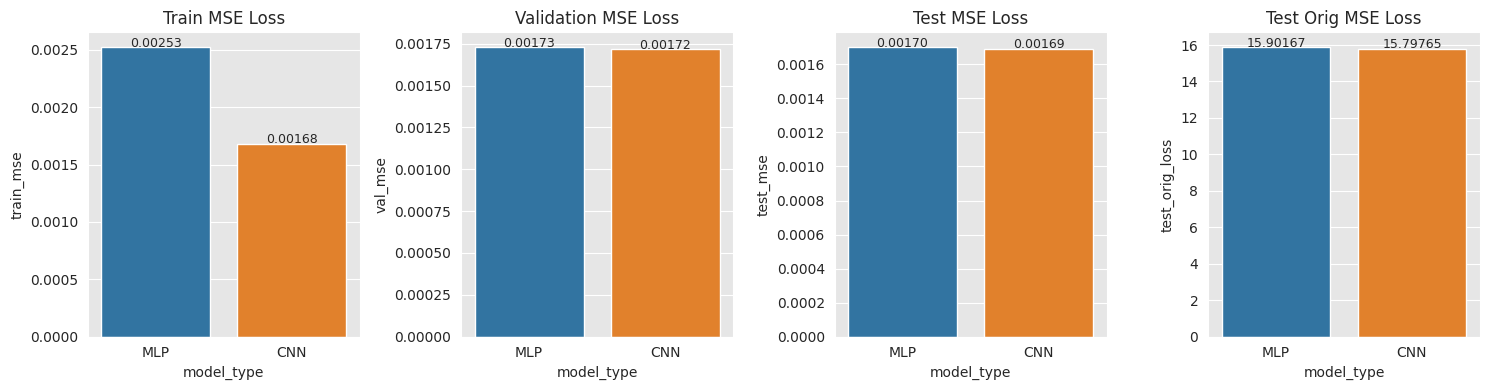

In [ ]:
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(15, 4)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

bar0  = sns.barplot(x='model_type', y='train_mse', hue='model_type', data=result_concat.T, ax=ax[0])
bar1 =  sns.barplot(x='model_type', y='val_mse', hue='model_type', data=result_concat.T, ax=ax[1])
bar2 = sns.barplot(x='model_type', y='test_mse', hue='model_type', data=result_concat.T, ax=ax[2])
bar3 = sns.barplot(x='model_type', y='test_orig_loss', hue='model_type', data=result_concat.T, ax=ax[3])

titles = ['Train MSE Loss', 'Validation MSE Loss', 'Test MSE Loss', 'Test Orig MSE Loss']

for i, bar in enumerate([bar0, bar1, bar2, bar3]):
    ax[i].set_title(titles[i])
    for container in bar.containers:
        ax[i].bar_label(container, fmt='%.5f', label_type='edge', padding=-2, fontsize=9)

plt.tight_layout()
plt.show()

Predict 하기 _ MLP

In [ ]:
y_pred_mlp, y_true_mlp = predict_best_model_1(partition, 'exp203_test-5bf244')

In [ ]:
np.mean((y_pred_mlp - y_true_mlp)**2)

np.float32(0.001700322)

In [ ]:
y_pred_mlp.shape

(1986, 1, 304, 2)

In [ ]:
y_pred_original = y_scaler.inverse_transform(y_pred_mlp.reshape(-1, 2)).reshape(y_pred_mlp.shape)
y_true_original = y_scaler.inverse_transform(y_true_mlp.reshape(-1, 2)).reshape(y_true_mlp.shape)

In [ ]:
np.mean((y_pred_original - y_true_original)**2)

np.float32(15.87145)

In [ ]:
selected_pred = y_pred_original[:, 0, :, -1]
selected_true = y_true_original[:, 0, :, -1]

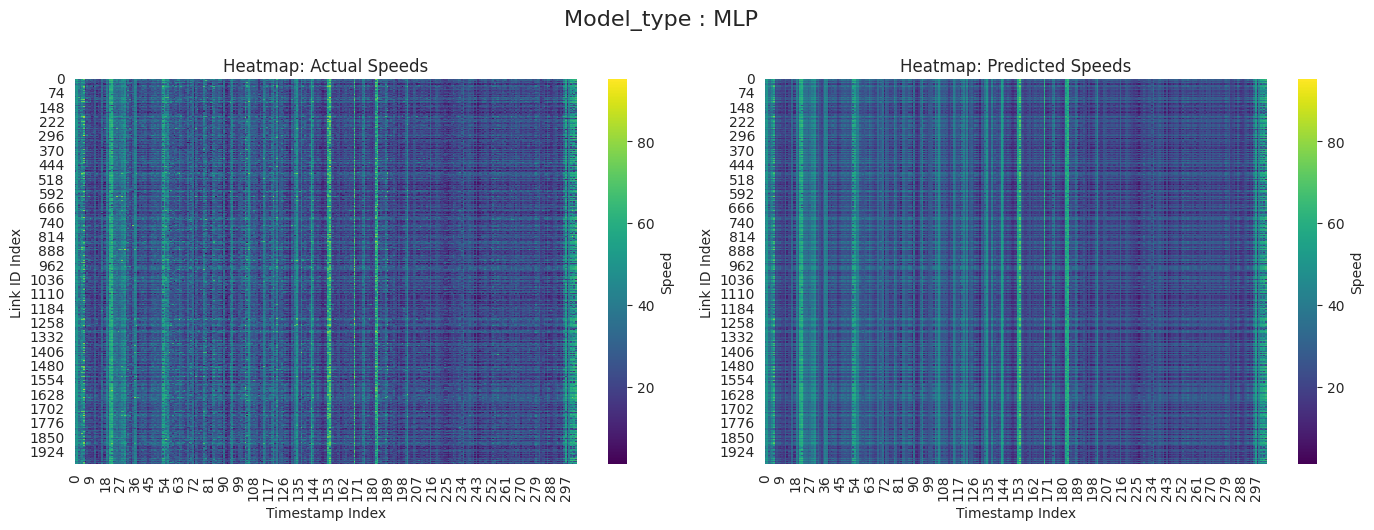

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5))

vmin = min(selected_true.min(), selected_pred.min())
vmax = max(selected_true.max(), selected_pred.max())

sns.heatmap(selected_true, ax=ax[0], cmap='viridis', cbar_kws={'label': 'Speed'}, vmin=vmin, vmax=vmax)
ax[0].set_title('Heatmap: Actual Speeds')
ax[0].set_xlabel('Timestamp Index')
ax[0].set_ylabel('Link ID Index')

sns.heatmap(selected_pred, ax=ax[1], cmap='viridis', cbar_kws={'label': 'Speed'}, vmin=vmin, vmax=vmax)
ax[1].set_title('Heatmap: Predicted Speeds')
ax[1].set_xlabel('Timestamp Index')
ax[1].set_ylabel('Link ID Index')

plt.suptitle('Model_type : MLP', fontsize=16, x=0.47, y=1.02)
plt.subplots_adjust(wspace=0.1)

Predict 하기 _ CNN

In [ ]:
y_pred_cnn, y_true_cnn = predict_best_model_1(partition, 'exp206_test')

In [ ]:
y_pred_original = y_scaler.inverse_transform(y_pred_cnn.reshape(-1, 2)).reshape(y_pred_cnn.shape)
y_true_original = y_scaler.inverse_transform(y_true_cnn.reshape(-1, 2)).reshape(y_true_cnn.shape)

In [ ]:
np.mean((y_pred_original - y_true_original)**2)

np.float32(15.801285)

In [ ]:
selected_pred = y_pred_original[:, 0, :, -1]
selected_true = y_true_original[:, 0, :, -1]

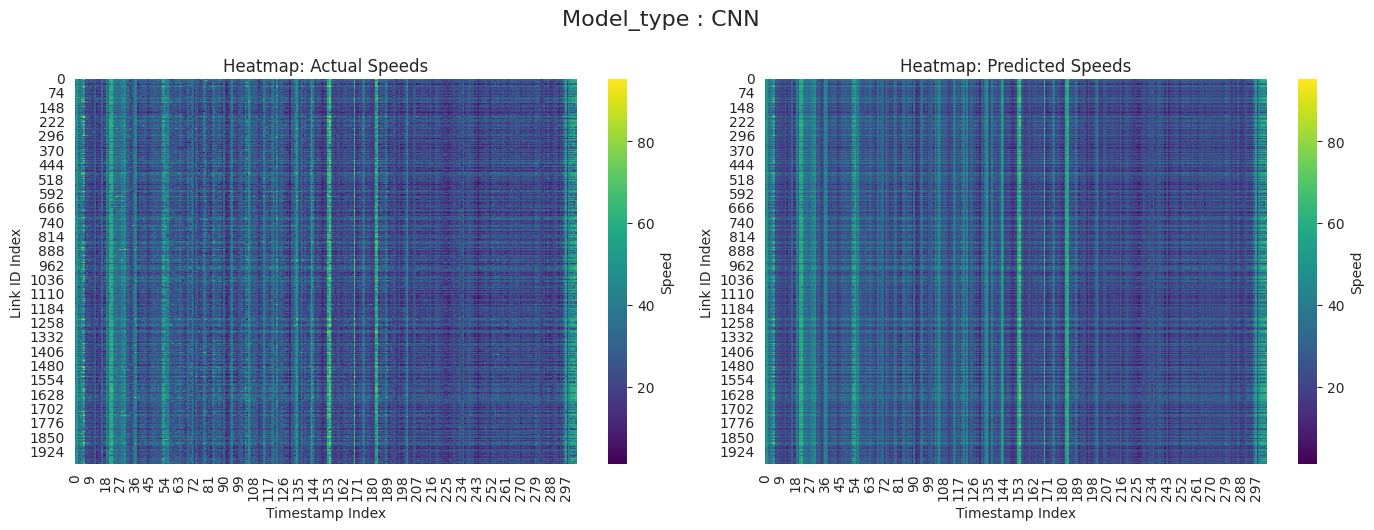

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5))

vmin = min(selected_true.min(), selected_pred.min())
vmax = max(selected_true.max(), selected_pred.max())

sns.heatmap(selected_true, ax=ax[0], cmap='viridis', cbar_kws={'label': 'Speed'}, vmin=vmin, vmax=vmax)
ax[0].set_title('Heatmap: Actual Speeds')
ax[0].set_xlabel('Timestamp Index')
ax[0].set_ylabel('Link ID Index')

sns.heatmap(selected_pred, ax=ax[1], cmap='viridis', cbar_kws={'label': 'Speed'}, vmin=vmin, vmax=vmax)
ax[1].set_title('Heatmap: Predicted Speeds')
ax[1].set_xlabel('Timestamp Index')
ax[1].set_ylabel('Link ID Index')

plt.suptitle('Model_type : CNN', fontsize=16, x=0.47, y=1.02)
plt.subplots_adjust(wspace=0.1)